# Trabajo Final - Predicción de fraude aduanero

Tutora: Maria Soledad Gutiérrez;
Alumnos: Joaquin Rossi, Jennifer Sanchez, Santiago Tedoldi

## Observaciones ##

**Avances, respecto de la 3er entrega:**

1- Partimos el dataset en data historica (2013 y 1er semestre del 2014) y data nueva (2do semestre del 2014)

2- Usamos la data histórica para hacer target encoding, generando para las variables categóricas nominales (OFFICE, IMPORTER, TARIFF.CODE, ORIGIN y sus combinaciones) tablas con información de los fraudes detectados para cada código.
Hicimos: la suma de fraude, la tasa de fraude y flags de riesgo (alto, medio, moderado y bajo) que indica el quartil al que pertenece cada código (según la suma y la tasa de fraudes).

3- Antes de procesar la data nueva, se aplica el feature enginering y se hace un JOIN con las tablas del punto 2.

4- Ampliamos la instancia de modelado de prueba, para evaluar el threshold de probabilidad óptimo para modelos de XGB, LogisticRegression y LGBM. Graficamos tanto la curva ROC, como la curva Precision vs. Recall.

5- También exploramos otras alternativas al resampleo, como el uso del hyperparámetro de class weight.

**Conclusiones:**

El F1 máximo obtenido ronda el 40%. Esto, pudiendo contar con un alto Recall, pero una baja Precision.

Desde el punto de vista del negocio aduanero, tener un alto Recall es fundamental para evitar potenciales fraudes. Sin embargo, mejorar la Precision puede aumentar la eficiencia operativa de las aduanas, mientras se reducen los tiempos y los costos del comercio internacional.

**Ideas para futuros trabajos:**

- Desarrollar modelos de clasificación que se enfoquen en un tipo de mercadería más específico. Por ejemplo, podemos enfocar la predicción de fraude a las máquinas, los automóviles o el material electrico (códigos tarifarios que comienzan en 84, 85 o 87). Enfocar el análisis en modelos de detección para mercaderías específicas, puede lograr las mejoras buscadas en los modelos, aunque demandaría un nuevo tratamiento de datos.

- Explorar la aplicación de técnicas de deep learning, para tratar de mejorar el rendimiento de las predicciones.


# Dependencias

In [1]:
## Importamos la librerias
import pandas as pd
import numpy as np

import itertools

import warnings
warnings.simplefilter('ignore')

# Manejo de directorios
import os

## Gráficas
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
paleta_ppt = ['#a6bfa5','#c9d8c8', '#696969','#ff9800']

## Preprocesamiento

# Librearias para normalizar
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

## Modelling Libraries

#from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression 

#from catboost import CatBoostClassifier
#!pip install lightgbm
import lightgbm as ltb
from lightgbm import LGBMClassifier

# Evaluation & CV Libraries
from sklearn.metrics import precision_score,accuracy_score,mean_absolute_error,mean_squared_error,r2_score,confusion_matrix
from sklearn.metrics import classification_report, plot_confusion_matrix,plot_roc_curve,roc_auc_score,f1_score,recall_score
from sklearn.metrics import roc_curve, auc
# train/test
from sklearn.model_selection import train_test_split

# hiperparameter tuning
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# sampleos
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline_imblearn

## saving results
#from pandas import ExcelWriter
import joblib
from datetime import date 


In [2]:
PATH_INPUT_DATA = os.path.join('../Primera entrega','csv_proyectoFinal.csv')
OUTPUT_RESULTS = 'Results'
OUTPUT_PROFILES = 'Historic profiles'

if not os.path.exists(OUTPUT_RESULTS):
    os.makedirs(OUTPUT_RESULTS)

if not os.path.exists(OUTPUT_PROFILES):
    os.makedirs(OUTPUT_PROFILES)

# Carga de Data

In [3]:
#Imput data

#Setting TARIFF.CODE datatype as str, to avoid losing information
dtype={'TARIFF.CODE':'str'}

df_original = pd.read_csv(PATH_INPUT_DATA, sep=";", dtype=dtype)
#mostrar numeros enteros 
pd.options.display.float_format = '{:.2f}'.format

In [4]:
#Diccionario para acceder de manera rápida a las descripciones de los campos
dict_data = {'year':'Año de la operación',
            'month':'Mes de la operación',
            'day':'Día de la operación',
            'OFFICE':'Oficina de aduana en la cual se declara la operación',
            'IMPORTER.TIN':'Identificación del Importador',
            'TARIFF.CODE':'Código de identificación del tipo de mercadería',
            'ORIGIN.CODE':'Código que identifica el país de origen de la mercadería',
            'CIF_USD_EQUIVALENT':'Valor CIF en dólares',
            'QUANTITY':'Cantidad de unidades',
            'GROSS.WEIGHT':'Peso bruto de la mercadería',
            'TOTAL.TAXES.USD':'Aranceles que abona en dólares',
            'illicit':'Fue fraude o no'
            }

#illicit es la variable target

In [5]:
df_original.head()

,year,month,day,OFFICE,IMPORTER.TIN,TARIFF.CODE,ORIGIN.CODE,CIF_USD_EQUIVALENT,QUANTITY,GROSS.WEIGHT,TOTAL.TAXES.USD,illicit
0,2013,1,1,OFFICE60,IMP545640,8703232225,CNTRY680,1727100.00,10.00,284870.00,34920.00,0
1,2013,1,1,OFFICE24,IMP252323,8703321220,CNTRY376,74500.00,10.00,1859940.00,5030.00,0
2,2013,1,1,NaN,IMP194834,8704212025,CNTRY680,26840.00,10.00,4528430.00,57060.00,0
3,2013,1,1,NaN,IMP668188,3901100000,CNTRY277,74120.00,20180.00,265460.00,31820.00,0
4,2013,1,1,NaN,IMP395619,8517180000,CNTRY759,27860.00,70440.00,NaN,5870.00,0


In [6]:
df_original.tail()

,year,month,day,OFFICE,IMPORTER.TIN,TARIFF.CODE,ORIGIN.CODE,CIF_USD_EQUIVALENT,QUANTITY,GROSS.WEIGHT,TOTAL.TAXES.USD,illicit
199995,2014,12,31,OFFICE168,IMPO19832,3926909710,CNTRY994,190560.00,10.00,1890.00,50.00,0
199996,2014,12,31,OFFICE296,IMPO10210,8704319941,CNTRY959,5320.00,2430.00,150.00,2340.00,1
199997,2014,12,31,OFFICE298,IMPO11255,5806200000,CNTRY994,110.00,580.00,240.00,50.00,0
199998,2014,12,31,OFFICE168,IMPO16962,5807109010,CNTRY376,28260.00,30.00,8220.00,50.00,0
199999,2014,12,31,OFFICE109,IMPO10548,3204110000,CNTRY976,860990.00,3336340.00,36060.00,101660.00,1


In [7]:
#dimensiones
df_original.shape

(200000, 12)

In [8]:
#Valores nules en %
percent_missing=df_original.isnull().sum()*100/len(df_original)
percent_missing

year                 0.00
month                0.00
day                  0.00
OFFICE               0.06
IMPORTER.TIN         0.00
TARIFF.CODE          0.01
ORIGIN.CODE          0.23
CIF_USD_EQUIVALENT   0.75
QUANTITY             0.24
GROSS.WEIGHT         0.19
TOTAL.TAXES.USD      0.03
illicit              0.00
dtype: float64

___________________________________________________________________________

# Análisis Exploratorio

In [9]:
# Análisis Exploratorio
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   year                200000 non-null  int64  
 1   month               200000 non-null  int64  
 2   day                 200000 non-null  int64  
 3   OFFICE              199873 non-null  object 
 4   IMPORTER.TIN        200000 non-null  object 
 5   TARIFF.CODE         199975 non-null  object 
 6   ORIGIN.CODE         199530 non-null  object 
 7   CIF_USD_EQUIVALENT  198496 non-null  float64
 8   QUANTITY            199529 non-null  float64
 9   GROSS.WEIGHT        199623 non-null  float64
 10  TOTAL.TAXES.USD     199944 non-null  float64
 11  illicit             200000 non-null  int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 18.3+ MB


Contamos con pocas variables numéricas, 4 sin contar la fecha. Debemos evaluar el uso del encoding en las variables categóricas.

In [10]:
#Porcentaje total de nulos %
percent_missing.sum()

1.5150000000000001

Identificamos variable target y separamos variables categóricas de numéricas:

In [11]:
allColumns = list(df_original.columns.values)
target = ['illicit']
categoricas = df_original.drop('illicit', axis = 1).select_dtypes('object').columns.tolist()
numericas = df_original.drop(['year','month','day','illicit'], axis = 1).select_dtypes('number').columns.tolist()

In [12]:
allColumns

['year',
 'month',
 'day',
 'OFFICE',
 'IMPORTER.TIN',
 'TARIFF.CODE',
 'ORIGIN.CODE',
 'CIF_USD_EQUIVALENT',
 'QUANTITY',
 'GROSS.WEIGHT',
 'TOTAL.TAXES.USD',
 'illicit']

## Análisis de la variable Target

In [13]:
def plot_target(data, save = False):
    '''
    Muestra un gráfico de barras para el campo illicit con anotaciones de conteo absoluto y porcentual
    
    Argumentos:
    ----------
    data ---------- dataframe, debe contener la columna illicit para graficar
    save ---------- [Opcional] booleana, flag para guardar la imagen en formato png (default=False)

    '''
    sns.set(font_scale=1.4)
    sns.set_style("white")

    plt.figure(figsize=(10,5))

    g = sns.countplot(x='illicit', data=data, palette = [paleta_ppt[0], paleta_ppt[0]])
    g.set_ylabel('Conteo de ilicitos')
    g.set_xlabel('')
    plt.title('Conteo de valores para la variable Target: illicit\n', fontsize=22)
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)

    # realizamos las anotaciones
    porcentajes = 100*data.illicit.value_counts(normalize=True)
    for p, porc in zip(g.patches, porcentajes):
        g.annotate(
                   '{:.2f}%\n({:1.0f})'.format(porc, p.get_height()),     # texto
                    (p.get_x()+p.get_width() /2. , 0.45*p.get_height()),  # posición
                    ha = 'center', va = 'center', fontsize=18             # propiedades
                  )


    # guardamos la imagen en un archivo jpg
    if save:
        plt.savefig(os.path.join('Results','plot_target_'+str(date.today())+'.png'), bbox_inches='tight', transparent=True)
    plt.show()

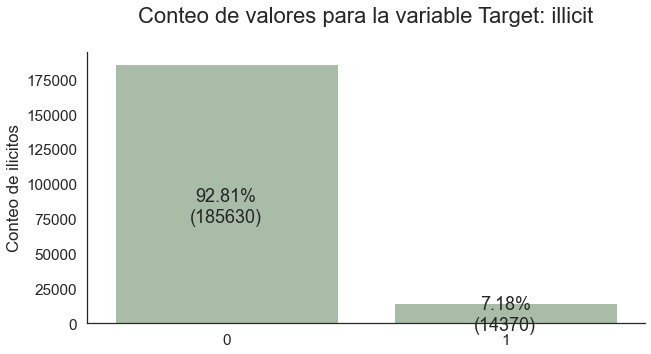

In [14]:
plot_target(df_original)

Observaciones:

- sólo un 7% (aprox) de las operaciones controladas son ilícitas, por tanto se trata de un dataset desbalanceado.
- se aplicarán estrategias de balanceo.

## Análisis de variables Categóricas

In [15]:
def counting(data, col, dropna=False, acumulado = False):
    '''
    Esta funcion retorna un dataframe con los conteos absolutos, relativos y porcentual
    
    argumentos:
    -----------
    - data: ----- dataframe, es el dataframe de donde queremos calcular
    - col: ------------ str, nombre de la columna con valores categóricos
    - dropna: --------- Booleana, para incluir el conteo de NaN (default False)
    - acumulado: ------ Booleana, para incluir columna de valores acumulados (default False)
    
    return:
    ------
     dataframe
    '''
    df_abs = data[col].value_counts(dropna=dropna).to_frame('absoluto').reset_index()
    df_porc = data[col].value_counts(dropna=dropna, normalize=True).mul(100).to_frame('porcentual').reset_index()
    
    if acumulado:
        acum = 0
        for i, row in df_porc.iterrows():
            acum+=df_porc.loc[i, 'porcentual']
            df_porc.loc[i, 'acumulado'] = acum

    return pd.merge(df_abs, df_porc, on = 'index').rename(columns={'index':col})

In [16]:
for col in categoricas:
    print(counting(df_original, col))
    print('--'*20)

       OFFICE  absoluto  porcentual
0    OFFICE51     37399       18.70
1    OFFICE59     18585        9.29
2   OFFICE168     14561        7.28
3   OFFICE187     12147        6.07
4   OFFICE127     11052        5.53
..        ...       ...         ...
69  OFFICE252       243        0.12
70  OFFICE101       242        0.12
71  OFFICE117       242        0.12
72  OFFICE234       229        0.11
73        NaN       127        0.06

[74 rows x 3 columns]
----------------------------------------
      IMPORTER.TIN  absoluto  porcentual
0        IMPO19420      1272        0.64
1        IMPO11284      1217        0.61
2        IMP826164      1087        0.54
3        IMPO19469      1005        0.50
4        IMP173637       908        0.45
...            ...       ...         ...
15343    IMP119502         1        0.00
15344    IMP814805         1        0.00
15345    IMP504119         1        0.00
15346    IMP422908         1        0.00
15347    IMPO14910         1        0.00

[15348 rows

Observaciones:

- Todas las variables categóricas son NOMINALES, por lo que requerirían one-hot-encoding
- Sin embargo, la cantidad de tipos distintos es demasiado grande (más de 21 mil en total), por lo que el one-hot-encoding daría miles de columnas a nuestro data frame

    OFFICE: 73
    IMPORTER.TIN: 15347
    TARIFF.CODE: 6334
    ORIGIN.CODE: 131
    
    Total: 21885

- No tenemos variables ORDINALES, por lo que se descarta el ordinal encoding y el mapeo

Abordaje:
 
Se partirá el dataset en datos históricos (2013 y 1er Sem 2014) y nuevos (2do Sem 2014).
Con los datos históricos, se utilizará **target encoding** y métodos análogos para generar nuevas variables que tengan información sobre las variables categóricas, relacionadas con la variable target. A continuación, se crearan tablas con información del riesgo propio de OFFICE, IMPORTER.TIN, TARIFF.CODE, ORIGIN.CODE, y sus combinaciones.

Luego, en el preprocesing, se hará un JOIN/MERGE de los datos nuevos (2do Sem 2014) con las tablas de riesgo antes mencionadas.

## Análisis de variables Numéricas

In [17]:
 def plot_numeric(data, col_num, n, save=False):
    '''
    Esta funcion grafica una muestra de n registros de las variables numéricas del dataset 
    
    argumentos:
    -----------
    - data: ----- dataframe, es el dataframe de donde queremos calcular
    - col: ------------ str, lista de las columnas con valores numéricos
    - n: ------------ int, cantidad de registros a graficar
    save ---------- [Opcional] booleana, flag para guardar la imagen en formato png (default=False)
    
    return:
     gráficas
    ------
    '''

    data_sample = data[col_num][:n]
    
    #Grafica usando: 
    #-displot con fit=norm para las variables float
    #-countplot para las variables integer
    plt.figure(figsize=(25,100))
    for index, (colname,serie) in enumerate(data_sample.iteritems()):
        plt.subplot(31,1, index+1)
        if pd.api.types.is_float_dtype(serie) is True:
            sns.distplot(serie,fit=norm)
            plt.axvline(np.mean(serie), color='slategrey')

        elif pd.api.types.is_integer_dtype(serie) is True:
            sns.countplot(serie)
    
        # plt.rcParams['figure.figsize'] = (15,60)
        plt.title(colname, fontsize=14)
        plt.xlabel('') 
        plt.tight_layout()

    # guardamos la imagen en un archivo jpg
    if save:
        plt.savefig(os.path.join('Results','plot_numeric_'+str(date.today())+'.png'), bbox_inches='tight', transparent=True)
    plt.show()


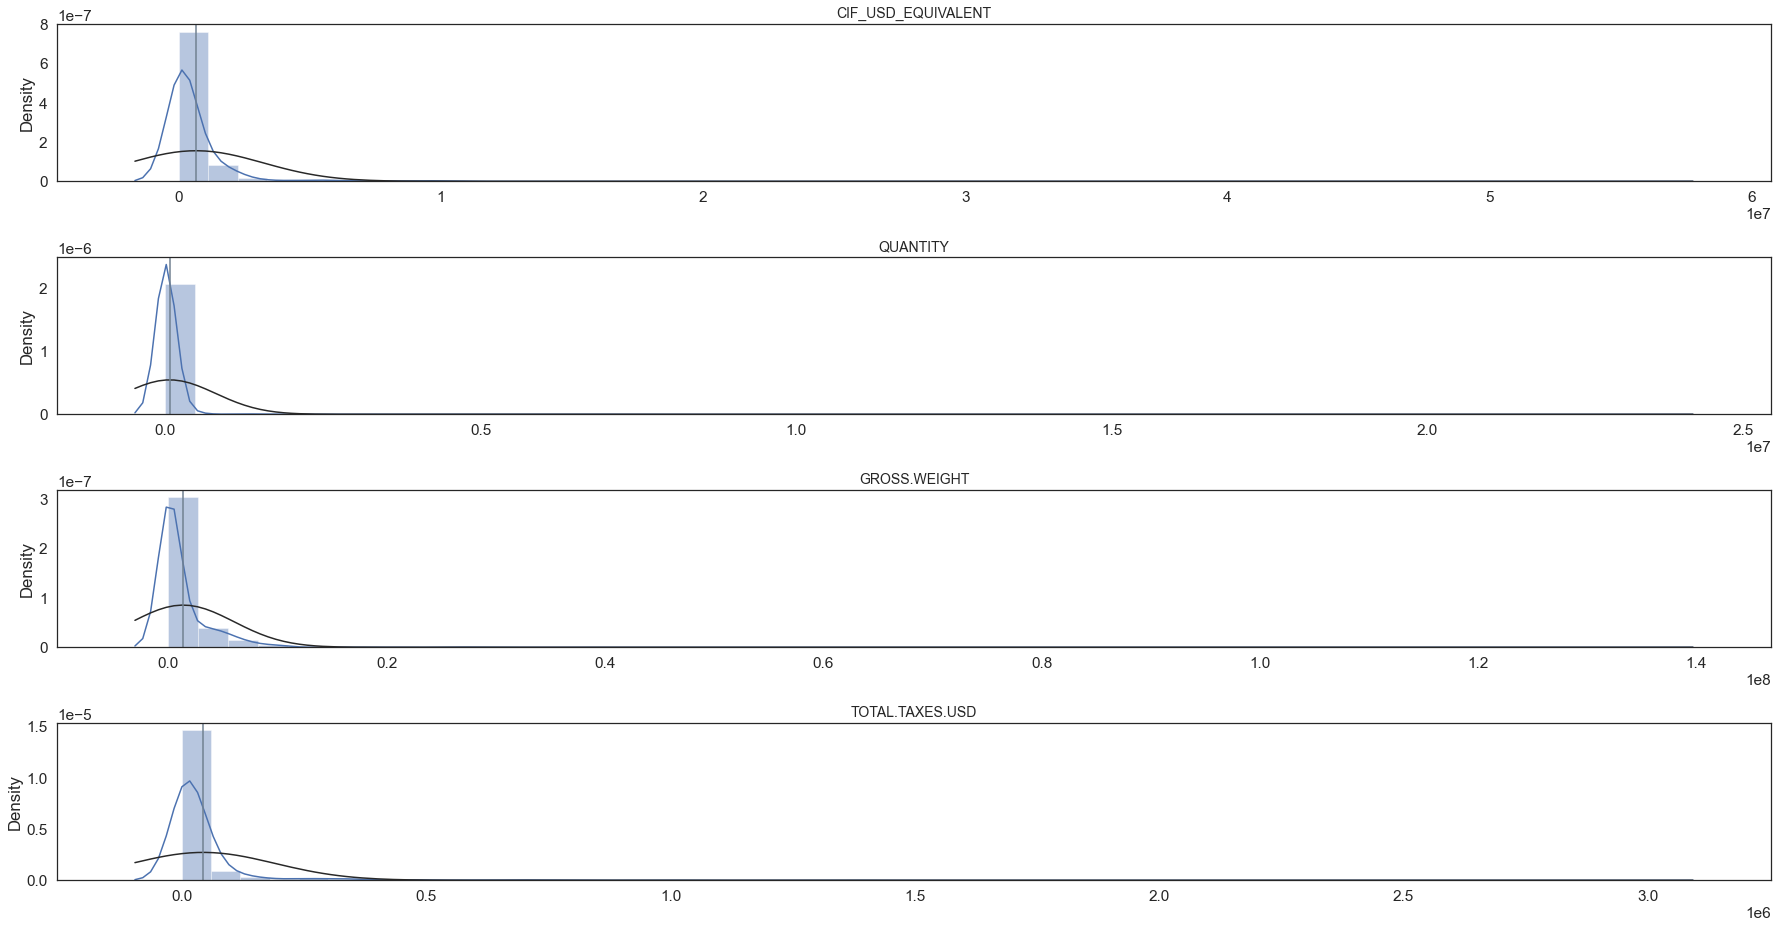

In [18]:
plot_numeric(df_original, numericas, 2000)

## Analisis Multivariable

In [19]:
df_original.describe()

,year,month,day,CIF_USD_EQUIVALENT,QUANTITY,GROSS.WEIGHT,TOTAL.TAXES.USD,illicit
count,200000.00,200000.00,200000.00,198496.00,199529.00,199623.00,199944.00,200000.00
mean,2013.43,6.40,15.74,581061.43,53906.09,926774.42,39196.76,0.07
std,0.50,3.52,8.74,2815878.88,566477.93,4947987.80,184600.66,0.26
min,2013.00,1.00,1.00,20.00,10.00,10.00,0.00,0.00
25%,2013.00,4.00,8.00,23360.00,30.00,1345.00,50.00,0.00
50%,2013.00,6.00,16.00,56540.00,840.00,17110.00,5180.00,0.00
75%,2014.00,10.00,23.00,296812.50,6850.00,289620.00,30780.00,0.00
max,2014.00,12.00,31.00,171272620.00,93465820.00,637395200.00,36664623.00,1.00


In [20]:
#Genero los bins, máximo 5, para graficar luego

bins_CIF=[0,36000000,72000000,108000000,144000000,180000000]
labels_CIF=['0-36M','36M-72M','72M-108M','108M-144M','144M-180M']

bins_QUANTITY=[0,20000000,40000000,60000000,80000000,100000000]
labels_QUANTITY=['0-20M','20M-40M','40M-60M','60M-80M','80M-100M']

bins_WEIGHT=[0,140000000,280000000,420000000,560000000,700000000]
labels_WEIGHT=['0-140M','140M-280M','280M-420M','420M-560M','560M-700M']

bins_TAXES=[0,8000000,16000000,24000000,32000000,40000000]
labels_TAXES=['0-8M','8M-16M','16M-24M','24M-32M','32M-40M']

In [21]:
numericas

['CIF_USD_EQUIVALENT', 'QUANTITY', 'GROSS.WEIGHT', 'TOTAL.TAXES.USD']

In [22]:
def plot_multi_numeric(data,col_cat,bins,labels):
    data_tmp = data.copy()
    
    '''
    Esta funcion grafica la relación entre variables numéricas del dataset 
    
    argumentos:
    -----------
    - data: ----- dataframe, es el dataframe de donde queremos calcular
    - col_cat: str, nombre de la variable a cruzar con el resto
    - bins: list, particiones a realizar en dicha variable
    - labels: list, etiquetas para los bins

    return:
     gráficas
    ------
    '''

    #Bajo la cantidad de bins
    #Además, cambio los valores (agrego un cero), según me indica el describe() del dataframe
    data_tmp[col_cat] = pd.cut(data_tmp[col_cat], bins=bins, labels=labels)
    
    
    for col_i in numericas:
        if col_i != col_cat:

      
            fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(18,5))
            sns.scatterplot(x=col_cat, y = col_i, data = data, ax=axes[0], hue='illicit')

            #Gráfico 2
            #plt.figure(figsize=(18,5))
            sns.boxplot(x=col_cat, y=col_i, data=data_tmp, order=labels, palette=[paleta_ppt[1]], ax=axes[1])
            plt.show()

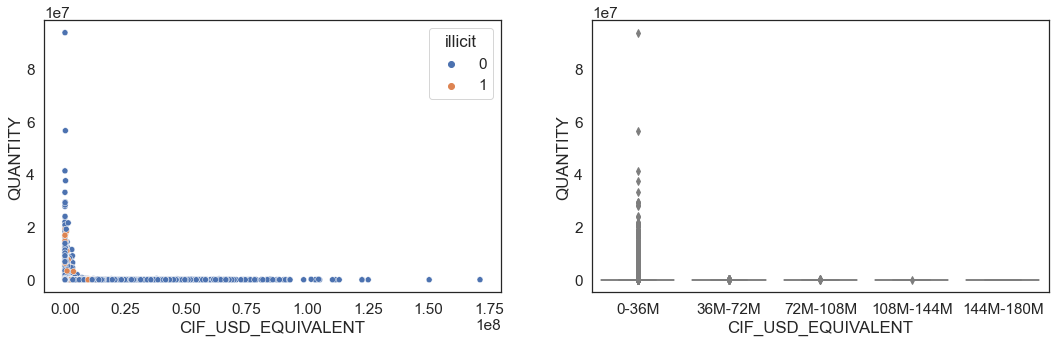

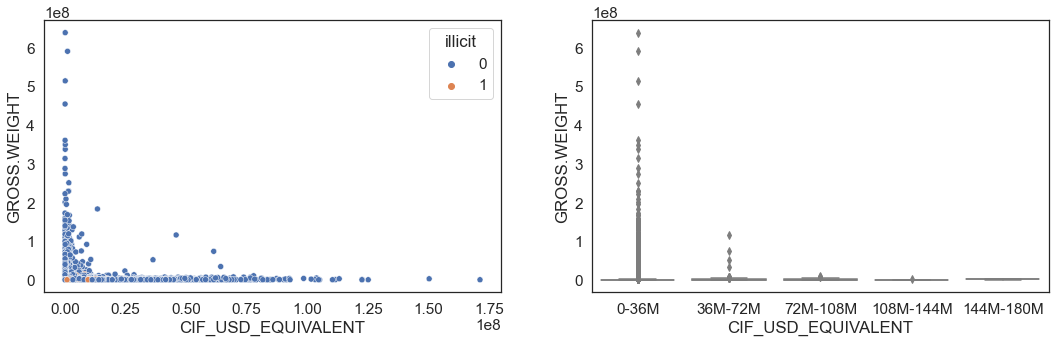

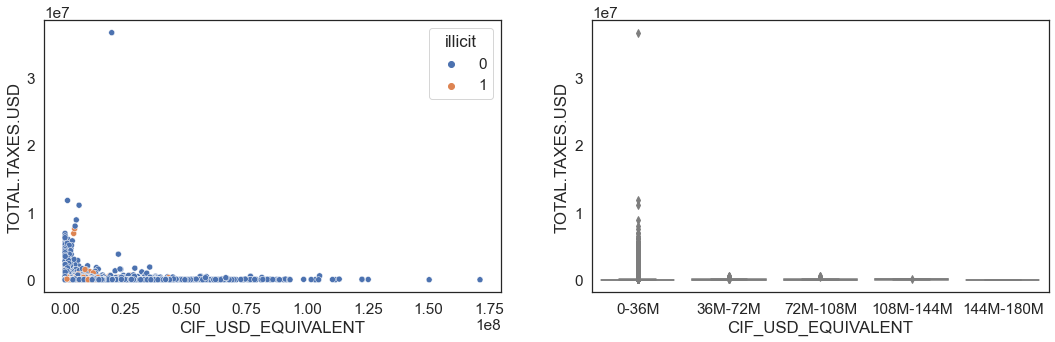

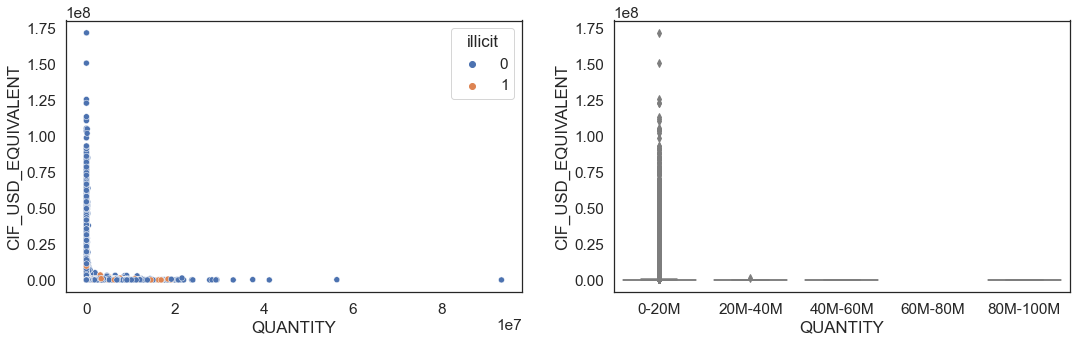

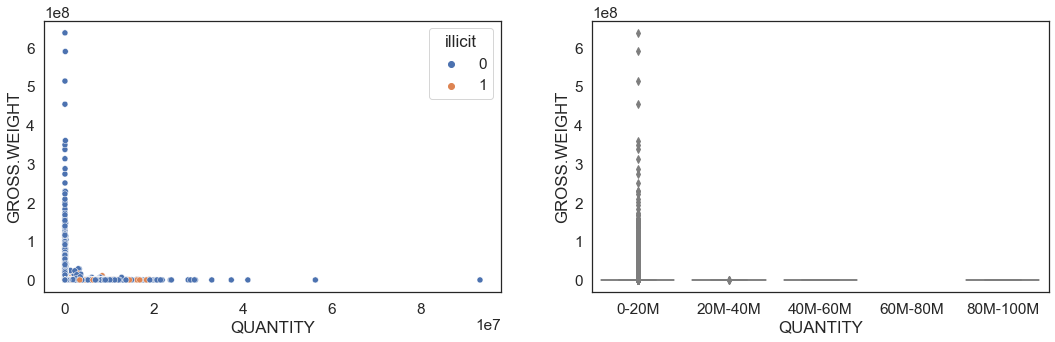

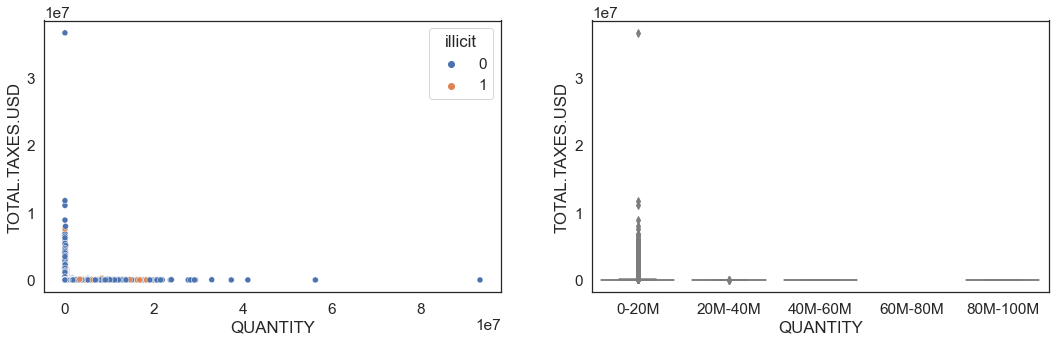

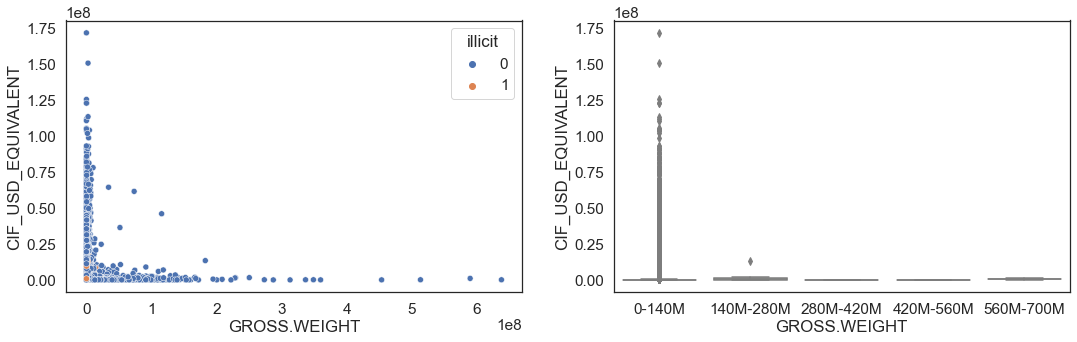

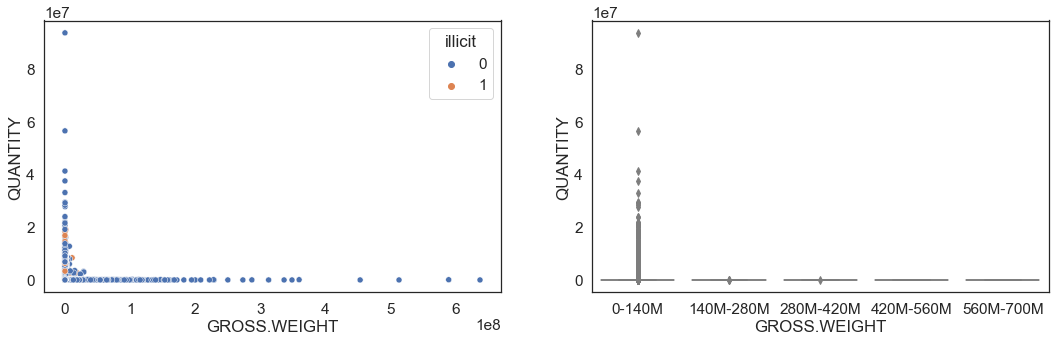

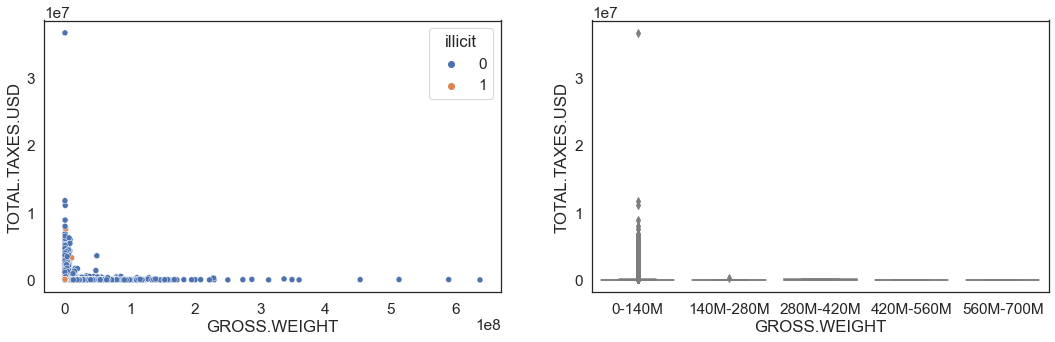

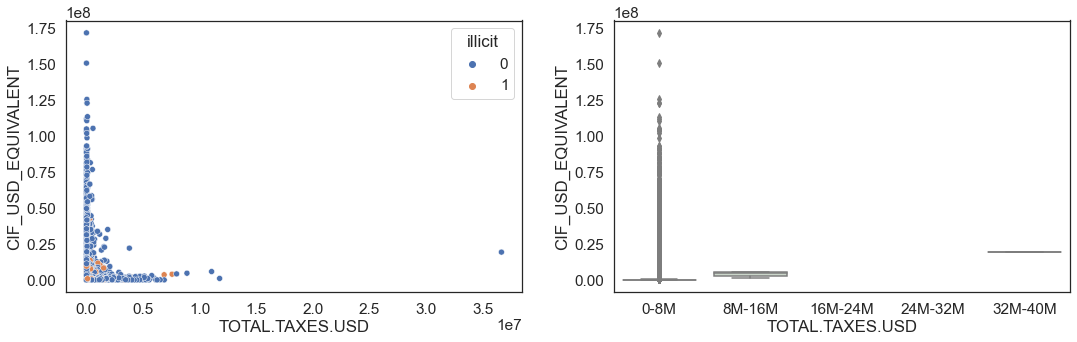

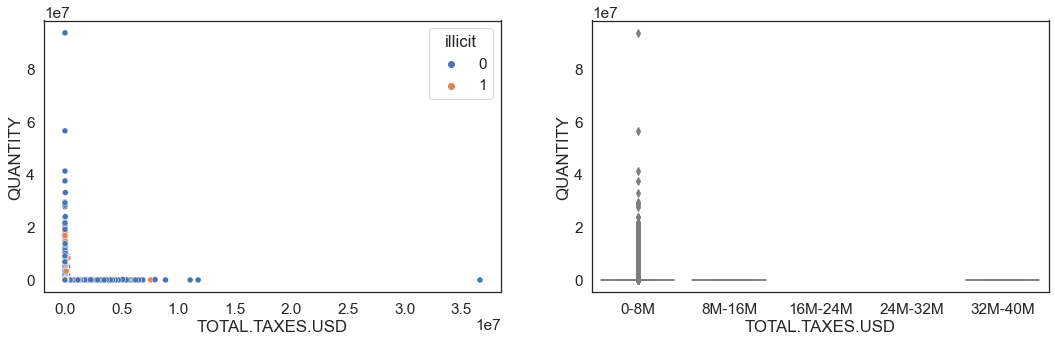

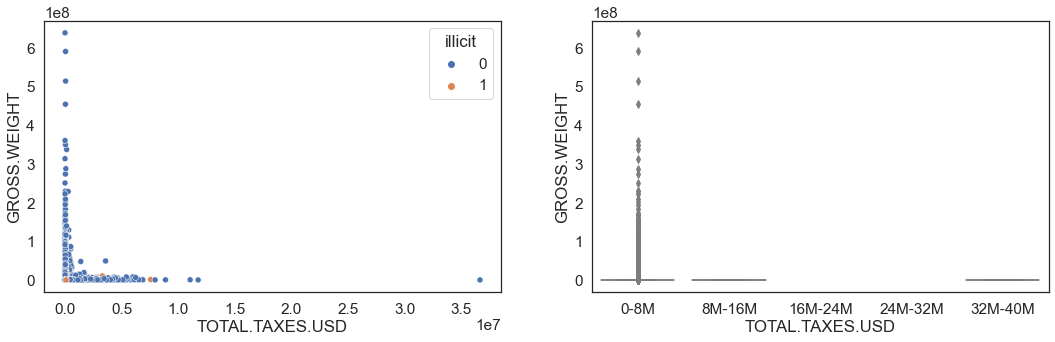

In [23]:
#Podría mejorarse con un for, pero habría que generar clases
plot_multi_numeric(df_original,'CIF_USD_EQUIVALENT',bins_CIF,labels_CIF)
plot_multi_numeric(df_original,'QUANTITY',bins_QUANTITY,labels_QUANTITY)
plot_multi_numeric(df_original,'GROSS.WEIGHT',bins_WEIGHT,labels_WEIGHT)
plot_multi_numeric(df_original,'TOTAL.TAXES.USD',bins_TAXES,labels_TAXES)

Evaluando la relacion númerica entre las variables CIF_USD_EQUIVALENT y TOTAL_TAXES.USD, parece necesario normalizar y escalar los datos, para que muestren valores comparables y poder visualizar mejor su relación.

_______________________________________________________________________

# Perfiles de riesgo

In [24]:
#Seeking for the historic information
last_year=df_original.year.max()
last_year

#Dejo como data histórica, a los datos del 2013 y primer semestre del 2014

df_historic = df_original[(df_original.year < last_year) | (df_original.month <= 6)]
df_historic

,year,month,day,OFFICE,IMPORTER.TIN,TARIFF.CODE,ORIGIN.CODE,CIF_USD_EQUIVALENT,QUANTITY,GROSS.WEIGHT,TOTAL.TAXES.USD,illicit
0,2013,1,1,OFFICE60,IMP545640,8703232225,CNTRY680,1727100.00,10.00,284870.00,34920.00,0
1,2013,1,1,OFFICE24,IMP252323,8703321220,CNTRY376,74500.00,10.00,1859940.00,5030.00,0
2,2013,1,1,NaN,IMP194834,8704212025,CNTRY680,26840.00,10.00,4528430.00,57060.00,0
3,2013,1,1,NaN,IMP668188,3901100000,CNTRY277,74120.00,20180.00,265460.00,31820.00,0
4,2013,1,1,NaN,IMP395619,8517180000,CNTRY759,27860.00,70440.00,NaN,5870.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
159566,2014,6,31,OFFICE185,IMPO11186,8418910000,CNTRY454,286650.00,26600.00,40080.00,50.00,0
159567,2014,6,31,OFFICE296,IMPO12250,4821109000,CNTRY994,81200.00,2180.00,5230.00,6330.00,0
159568,2014,6,31,OFFICE168,IMPO18189,8512909009,CNTRY994,14170.00,920.00,10.00,150.00,0
159569,2014,6,31,OFFICE204,IMPO11353,8533210000,CNTRY123,42340.00,3850.00,10.00,50.00,0


In [25]:
#Nueva data, solo el último semestre del 2014

df_new=df_original[(df_original.year == last_year) & (df_original.month > 6)]
df_new

,year,month,day,OFFICE,IMPORTER.TIN,TARIFF.CODE,ORIGIN.CODE,CIF_USD_EQUIVALENT,QUANTITY,GROSS.WEIGHT,TOTAL.TAXES.USD,illicit
159571,2014,7,1,OFFICE96,IMP782893,8517180000,CNTRY919,64950.00,11180.00,16040.00,13130.00,0
159572,2014,7,1,OFFICE51,IMP440223,8703321922,CNTRY680,71370.00,10.00,278110.00,12780.00,0
159573,2014,7,1,OFFICE51,IMP648653,8704212025,CNTRY680,78320.00,10.00,17440.00,14940.00,0
159574,2014,7,1,OFFICE34,IMP324025,8481800000,CNTRY771,17180.00,30.00,69950.00,250660.00,0
159575,2014,7,1,OFFICE81,IMP356872,8462390000,CNTRY184,431440.00,16860.00,674590.00,183970.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2014,12,31,OFFICE168,IMPO19832,3926909710,CNTRY994,190560.00,10.00,1890.00,50.00,0
199996,2014,12,31,OFFICE296,IMPO10210,8704319941,CNTRY959,5320.00,2430.00,150.00,2340.00,1
199997,2014,12,31,OFFICE298,IMPO11255,5806200000,CNTRY994,110.00,580.00,240.00,50.00,0
199998,2014,12,31,OFFICE168,IMPO16962,5807109010,CNTRY376,28260.00,30.00,8220.00,50.00,0


Todo lo previo al último semestre, será data historica

In [26]:
def risk_profiling(data, to_comb, save=False):
    
    df_ = data.copy() # Para evitar cambios en el dataset original
        
    '''
    Esta funcion aplica target encoding y genera perfiles de riesgo
    
    argumentos:
    -----------
    - data: dataframe, es el dataframe que vamos a procesar como data historica
    - to_comb: list, variables categóricas a procesar por la función 
    - save: bool, indication whether to save tables
    
    return:
    df_: dataframe con el target encoding y los perfiles de riesgo asignados
    if save: guarda en OUTPUT_PROFILES las tablas
    tables: list, con los nombres de las tablas generadas
    ------
    '''
    risk_tables = []
    #------------------------------
    #------------------------------

    # Deleting nulls in columns to process
    df_.dropna(subset = to_comb, inplace = True)
    df_.dropna(subset = ['illicit'], inplace = True)

    # Aseguramos que los campos a combinar sean string
    df_.loc[:,to_comb] = df_.loc[:,to_comb].astype(str)
    
    # Combinaciones de atributos a combinar
    combinations = list(itertools.combinations(to_comb, 2))

    # Loop para concatenar las combinaciones, con un '&&' 
    for (cat1, cat2) in combinations:
        colName = cat1 + '&&' + cat2
        df_.loc[:,colName] = df_.loc[:,cat1]+'&&'+df_.loc[:,cat2] #Uso el & para que no se filtre CIF_USD_EQUIVALENT
    
    profile_candidates = ['OFFICE', 'IMPORTER.TIN','TARIFF.CODE', 'ORIGIN.CODE'] + [col for col in df_.columns if '&&' in col]
    print("profile_candidates",profile_candidates)
    #------------------------------
    
    ## Riesgo según suma y media 'Encoded_sum' & 'Encoded_Mean'

    for feature in profile_candidates: #going over features to assing risk
        #DF with the data enconded
        df_encoded = df_.illicit.groupby(df_[feature]).agg(['sum','mean'])
        # print(df_encoded)
        df_encoded.rename(columns = {'sum': feature+'_T-Encoded_Sum', 'mean': feature+'_T-Encoded_Mean'},inplace=True)
        #MERGE left to bring encoded data to the df_ trated 

        df_ = df_.merge(df_encoded, how='left', on=feature)

        #Saving Target encoding list for feature
        csv_name = feature+'_T-Encoded_Hist.csv'
        path_name = os.path.join(OUTPUT_PROFILES,csv_name)
       
        if save:
            df_encoded.to_csv(path_name)
           
        risk_tables += [csv_name] #name of the new risk table

    #------------------------------
    ## Perfiles de Riesgo según el Quartile de la suma de frudes 'QAcc'

    # for feature in profile_candidates: #going over features to assing risk
        df_[feature+'_QSum_Risk'] = pd.qcut(df_[feature+'_T-Encoded_Sum'], q=[0, .25, .50, .75, 1], labels = False, duplicates = 'drop')   

     ## Perfiles de Riesgo según el Quartile de la media de frudes 'QMean'
        df_[feature+'_QMean_Risk'] = pd.qcut(df_[feature+'_T-Encoded_Mean'], q=[0, .25, .50, .75, 1], labels = False, duplicates = 'drop') 

    ## Saving risk profiling in csv format
        df_profile = df_.drop_duplicates(subset=[feature]) #Subset of feature unique values
        df_profile.reset_index(drop=True, inplace=True)

        df_profile = pd.concat([df_profile[feature], df_profile.filter(like=feature+'_Q')], axis=1) #Concatenation between feature_column and profile_columns
        
        #Naming and saving historic risk profile
        csv_name=feature+'_Q_Risk_Hist.csv'
        path_name = os.path.join(OUTPUT_PROFILES,csv_name)
        
        if save:
            df_profile.to_csv(path_name)
        
        risk_tables += [csv_name]


    return df_,risk_tables

In [27]:
df_historic,risk_tables=risk_profiling(df_historic,categoricas,save=False) #Lo dejo sin guardado, ya tenemos generadas las tablas

profile_candidates ['OFFICE', 'IMPORTER.TIN', 'TARIFF.CODE', 'ORIGIN.CODE', 'OFFICE&&IMPORTER.TIN', 'OFFICE&&TARIFF.CODE', 'OFFICE&&ORIGIN.CODE', 'IMPORTER.TIN&&TARIFF.CODE', 'IMPORTER.TIN&&ORIGIN.CODE', 'TARIFF.CODE&&ORIGIN.CODE']


In [28]:
pd.options.display.max_columns = None  #visualizar todas columnas
df_historic

,year,month,day,OFFICE,IMPORTER.TIN,TARIFF.CODE,ORIGIN.CODE,CIF_USD_EQUIVALENT,QUANTITY,GROSS.WEIGHT,TOTAL.TAXES.USD,illicit,OFFICE&&IMPORTER.TIN,OFFICE&&TARIFF.CODE,OFFICE&&ORIGIN.CODE,IMPORTER.TIN&&TARIFF.CODE,IMPORTER.TIN&&ORIGIN.CODE,TARIFF.CODE&&ORIGIN.CODE,OFFICE_T-Encoded_Sum,OFFICE_T-Encoded_Mean,OFFICE_QSum_Risk,OFFICE_QMean_Risk,IMPORTER.TIN_T-Encoded_Sum,IMPORTER.TIN_T-Encoded_Mean,IMPORTER.TIN_QSum_Risk,IMPORTER.TIN_QMean_Risk,TARIFF.CODE_T-Encoded_Sum,TARIFF.CODE_T-Encoded_Mean,TARIFF.CODE_QSum_Risk,TARIFF.CODE_QMean_Risk,ORIGIN.CODE_T-Encoded_Sum,ORIGIN.CODE_T-Encoded_Mean,ORIGIN.CODE_QSum_Risk,ORIGIN.CODE_QMean_Risk,OFFICE&&IMPORTER.TIN_T-Encoded_Sum,OFFICE&&IMPORTER.TIN_T-Encoded_Mean,OFFICE&&IMPORTER.TIN_QSum_Risk,OFFICE&&IMPORTER.TIN_QMean_Risk,OFFICE&&TARIFF.CODE_T-Encoded_Sum,OFFICE&&TARIFF.CODE_T-Encoded_Mean,OFFICE&&TARIFF.CODE_QSum_Risk,OFFICE&&TARIFF.CODE_QMean_Risk,OFFICE&&ORIGIN.CODE_T-Encoded_Sum,OFFICE&&ORIGIN.CODE_T-Encoded_Mean,OFFICE&&ORIGIN.CODE_QSum_Risk,OFFICE&&ORIGIN.CODE_QMean_Risk,IMPORTER.TIN&&TARIFF.CODE_T-Encoded_Sum,IMPORTER.TIN&&TARIFF.CODE_T-Encoded_Mean,IMPORTER.TIN&&TARIFF.CODE_QSum_Risk,IMPORTER.TIN&&TARIFF.CODE_QMean_Risk,IMPORTER.TIN&&ORIGIN.CODE_T-Encoded_Sum,IMPORTER.TIN&&ORIGIN.CODE_T-Encoded_Mean,IMPORTER.TIN&&ORIGIN.CODE_QSum_Risk,IMPORTER.TIN&&ORIGIN.CODE_QMean_Risk,TARIFF.CODE&&ORIGIN.CODE_T-Encoded_Sum,TARIFF.CODE&&ORIGIN.CODE_T-Encoded_Mean,TARIFF.CODE&&ORIGIN.CODE_QSum_Risk,TARIFF.CODE&&ORIGIN.CODE_QMean_Risk
0,2013,1,1,OFFICE60,IMP545640,8703232225,CNTRY680,1727100.00,10.00,284870.00,34920.00,0,OFFICE60&&IMP545640,OFFICE60&&8703232225,OFFICE60&&CNTRY680,IMP545640&&8703232225,IMP545640&&CNTRY680,8703232225&&CNTRY680,464,0.07,2,2,7,0.03,3,2,41,0.04,2,2,699,0.02,3,1,1,0.05,0,1,4,0.04,1,2,40,0.02,2,2,0,0.00,0,0,2,0.02,1,1,9,0.03,2,2
1,2013,1,1,OFFICE24,IMP252323,8703321220,CNTRY376,74500.00,10.00,1859940.00,5030.00,0,OFFICE24&&IMP252323,OFFICE24&&8703321220,OFFICE24&&CNTRY376,IMP252323&&8703321220,IMP252323&&CNTRY376,8703321220&&CNTRY376,288,0.14,2,3,2,0.50,1,3,28,0.03,2,2,432,0.02,2,0,0,0.00,0,0,2,0.10,1,2,11,0.07,1,3,0,0.00,0,0,0,0.00,0,0,2,0.02,1,2
2,2013,1,1,OFFICE51,IMP165224,8703242900,CNTRY680,91000.00,19400.00,137690.00,5430.00,0,OFFICE51&&IMP165224,OFFICE51&&8703242900,OFFICE51&&CNTRY680,IMP165224&&8703242900,IMP165224&&CNTRY680,8703242900&&CNTRY680,939,0.03,3,0,4,0.02,2,2,58,0.03,2,2,699,0.02,3,1,0,0.00,0,0,12,0.02,2,1,162,0.01,3,0,0,0.00,0,0,1,0.01,0,1,11,0.02,2,2
3,2013,1,1,OFFICE40,IMP158220,8483200000,CNTRY680,27120.00,1350.00,16920.00,339800.00,0,OFFICE40&&IMP158220,OFFICE40&&8483200000,OFFICE40&&CNTRY680,IMP158220&&8483200000,IMP158220&&CNTRY680,8483200000&&CNTRY680,434,0.06,2,2,6,0.01,3,1,3,0.14,0,3,699,0.02,3,1,0,0.00,0,0,0,0.00,0,0,53,0.02,3,2,0,0.00,0,0,1,0.01,0,0,0,0.00,0,0
4,2013,1,1,OFFICE51,IMP284988,8703241128,CNTRY454,1715390.00,10.00,17450.00,36330.00,0,OFFICE51&&IMP284988,OFFICE51&&8703241128,OFFICE51&&CNTRY454,IMP284988&&8703241128,IMP284988&&CNTRY454,8703241128&&CNTRY454,939,0.03,3,0,3,0.15,1,3,133,0.01,3,1,262,0.07,1,2,0,0.00,0,0,52,0.01,2,1,28,0.03,2,2,0,0.00,0,0,0,0.00,0,0,6,0.02,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159055,2014,6,31,OFFICE185,IMPO11186,8418910000,CNTRY454,286650.00,26600.00,40080.00,50.00,0,OFFICE185&&IMPO11186,OFFICE185&&8418910000,OFFICE185&&CNTRY454,IMPO11186&&8418910000,IMPO11186&&CNTRY454,8418910000&&CNTRY454,201,0.07,1,2,1,0.12,0,3,0,0.00,0,0,262,0.07,1,2,0,0.00,0,0,0,0.00,0,0,2,0.04,0,2,0,0.00,0,0,0,0.00,0,0,0,0.00,0,0
159056,2014,6,31,OFFICE296,IMPO12250,4821109000,CNTRY994,81200.00,2180.00,5230.00,6330.00,0,OFFICE296&&IMPO12250,OFFICE296&&4821109000,OFFICE296&&CNTRY994,IMPO12250&&4821109000,IMPO12250&&CNTRY994,4821109000&&CNTRY994,178,0.03,0,0,2,0.01,1,1,10,0.01,2,1,346,0.02,1,0,0,0.00,0,0,1,0.01,0,1,14,0.01,2,0,0,0

In [29]:
df_historic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159060 entries, 0 to 159059
Data columns (total 58 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   year                                      159060 non-null  int64  
 1   month                                     159060 non-null  int64  
 2   day                                       159060 non-null  int64  
 3   OFFICE                                    159060 non-null  object 
 4   IMPORTER.TIN                              159060 non-null  object 
 5   TARIFF.CODE                               159060 non-null  object 
 6   ORIGIN.CODE                               159060 non-null  object 
 7   CIF_USD_EQUIVALENT                        157974 non-null  float64
 8   QUANTITY                                  158617 non-null  float64
 9   GROSS.WEIGHT                              158846 non-null  float64
 10  TOTAL.TAXES.USD     

Tenemos la data histórica (2013 y 1er Sem 2014), con las variables de perfiles de riesgo asignadas

Además, tenemos las tablas con los perfiles de riesgo, que luego vamos a usar para darle información a la data nueva (2014 2do Sem)

In [30]:
risk_tables

['OFFICE_T-Encoded_Hist.csv',
 'OFFICE_Q_Risk_Hist.csv',
 'IMPORTER.TIN_T-Encoded_Hist.csv',
 'IMPORTER.TIN_Q_Risk_Hist.csv',
 'TARIFF.CODE_T-Encoded_Hist.csv',
 'TARIFF.CODE_Q_Risk_Hist.csv',
 'ORIGIN.CODE_T-Encoded_Hist.csv',
 'ORIGIN.CODE_Q_Risk_Hist.csv',
 'OFFICE&&IMPORTER.TIN_T-Encoded_Hist.csv',
 'OFFICE&&IMPORTER.TIN_Q_Risk_Hist.csv',
 'OFFICE&&TARIFF.CODE_T-Encoded_Hist.csv',
 'OFFICE&&TARIFF.CODE_Q_Risk_Hist.csv',
 'OFFICE&&ORIGIN.CODE_T-Encoded_Hist.csv',
 'OFFICE&&ORIGIN.CODE_Q_Risk_Hist.csv',
 'IMPORTER.TIN&&TARIFF.CODE_T-Encoded_Hist.csv',
 'IMPORTER.TIN&&TARIFF.CODE_Q_Risk_Hist.csv',
 'IMPORTER.TIN&&ORIGIN.CODE_T-Encoded_Hist.csv',
 'IMPORTER.TIN&&ORIGIN.CODE_Q_Risk_Hist.csv',
 'TARIFF.CODE&&ORIGIN.CODE_T-Encoded_Hist.csv',
 'TARIFF.CODE&&ORIGIN.CODE_Q_Risk_Hist.csv']

_________________________________________________________________________________________

# Imputación, Label Encoding y Escalamiento

# Eliminación de fecha

Day | Month | Day

In [31]:
from datetime import datetime
def justificacion_borrar_fecha(data):
# los porcentajes de fraude se mantienen en el cambio de año
    illict_by_year= data.groupby(['year']).illicit.value_counts(normalize=True)
    print("-------Casos ilicitos por año--------")
    print(illict_by_year)
 
# tampoco se observan cambios significativos por mes.
    illict_by_month= data.groupby(['year', 'month']).illicit.value_counts(normalize=True).to_frame('%')
    print("-------Casos ilicitos por mes--------" )
    print(illict_by_month)
    
    # inconsistencias de días que no estan en calendario
    data.loc[(data.day>28)&(data.month==2), 'day'] = 28
    data.loc[(data.day>30)&(data.month==4), 'day'] = 30
    data.loc[(data.day>30)&(data.month==6), 'day'] = 30
    data.loc[(data.day>30)&(data.month==9), 'day'] = 30
    data.loc[(data.day>30)&(data.month==11), 'day'] = 30
#no hay relacion dia de semana
 
    df_cpy = data.copy()
    df_cpy['year'] = df_cpy['year'].astype(str)
    df_cpy['month'].replace({i: '0'+str(i) for i in range(1, 10)}, inplace=True)
    df_cpy['day'].replace({i: '0'+str(i) for i in range(1, 10)}, inplace=True)

    df_cpy['fecha'] = df_cpy["year"].str.cat(df_cpy[["month", "day"]].astype(str), sep="-")
    df_cpy['dia_semana'] = df_cpy['fecha'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date().weekday())
    
    print("-------Relación dia de semana--------" )
    print(df_cpy.groupby('dia_semana').illicit.value_counts())

In [32]:
justificacion_borrar_fecha(df_original)

-------Casos ilicitos por año--------
year  illicit
2013  0         0.93
      1         0.07
2014  0         0.92
      1         0.08
Name: illicit, dtype: float64
-------Casos ilicitos por mes--------
                      %
year month illicit     
2013 1     0       0.94
           1       0.06
     2     0       0.94
           1       0.06
     3     0       0.91
           1       0.09
     4     0       0.95
           1       0.05
     5     0       0.93
           1       0.07
     6     0       0.92
           1       0.08
     7     0       0.91
           1       0.09
     8     0       0.93
           1       0.07
     9     0       0.92
           1       0.08
     10    0       0.94
           1       0.06
     11    0       0.93
           1       0.07
     12    0       0.93
           1       0.07
2014 1     0       0.93
           1       0.07
     2     0       0.93
           1       0.07
     3     0       0.90
           1       0.10
     4     0       0.94
    

# Procesamiento

Comenzamos trabajando con el df_new, que es lo que vamos a procesar

In [33]:
#Creamos copia para poder volver de ser necesario
df_pre = df_new.copy()
#eliminación de la fecha, por no aportar al ML
df_pre.drop(['year','month','day'], axis = 1, inplace = True)

___________________________________________

# Prueba del cruce entre data nueva y las tablas de riesgo

In [34]:
categoricas

['OFFICE', 'IMPORTER.TIN', 'TARIFF.CODE', 'ORIGIN.CODE']

In [35]:
df_prueba1=df_pre.copy()

df_prueba1.loc[:,categoricas] = df_prueba1.loc[:,categoricas].astype(str)
df_prueba1.loc[:,categoricas] 

combinations = list(itertools.combinations(categoricas, 2))
combinations

[('OFFICE', 'IMPORTER.TIN'),
 ('OFFICE', 'TARIFF.CODE'),
 ('OFFICE', 'ORIGIN.CODE'),
 ('IMPORTER.TIN', 'TARIFF.CODE'),
 ('IMPORTER.TIN', 'ORIGIN.CODE'),
 ('TARIFF.CODE', 'ORIGIN.CODE')]

In [36]:
df_prueba=df_pre.copy()

df_prueba.loc[:,categoricas] = df_prueba.loc[:,categoricas].astype(str)

# Combinaciones de atributos a combinar
combinations = list(itertools.combinations(categoricas, 2))

# Loop para concatenar las combinaciones, con un '&&' 
for (cat1, cat2) in combinations:
    colName = cat1 + '&&' + cat2
    df_prueba.loc[:,colName] = df_prueba.loc[:,cat1]+'&&'+df_prueba.loc[:,cat2] #Uso el & para que no se filtre CIF_USD_EQUIVALENT

for table in risk_tables:

    # Leo cada tabla con la información histórica de riesgo
    PATH_INPUT_TABLE = os.path.join(OUTPUT_PROFILES,table)
    df_table = pd.read_csv(PATH_INPUT_TABLE)

    # Parche para eliminar columnas unnamed
    df_table.drop(df_table.columns[df_table.columns.str.contains('unnamed',case = False)], axis = 1, inplace = True)
    
    # Key para hacer el JOIN
    key=df_table.columns[0]
    print(key)
    # Me aseguro que key en df_table sea str
    df_table.loc[:,key] = df_table.loc[:,key].astype(str)
   
    # JOIN, por defaul es left join
    df_prueba = df_prueba.join(df_table.set_index(key), on = key, how ='left')

OFFICE
OFFICE
IMPORTER.TIN
IMPORTER.TIN
TARIFF.CODE
TARIFF.CODE
ORIGIN.CODE
ORIGIN.CODE
OFFICE&&IMPORTER.TIN
OFFICE&&IMPORTER.TIN
OFFICE&&TARIFF.CODE
OFFICE&&TARIFF.CODE
OFFICE&&ORIGIN.CODE
OFFICE&&ORIGIN.CODE
IMPORTER.TIN&&TARIFF.CODE
IMPORTER.TIN&&TARIFF.CODE
IMPORTER.TIN&&ORIGIN.CODE
IMPORTER.TIN&&ORIGIN.CODE
TARIFF.CODE&&ORIGIN.CODE
TARIFF.CODE&&ORIGIN.CODE


In [37]:
df_prueba

,OFFICE,IMPORTER.TIN,TARIFF.CODE,ORIGIN.CODE,CIF_USD_EQUIVALENT,QUANTITY,GROSS.WEIGHT,TOTAL.TAXES.USD,illicit,OFFICE&&IMPORTER.TIN,OFFICE&&TARIFF.CODE,OFFICE&&ORIGIN.CODE,IMPORTER.TIN&&TARIFF.CODE,IMPORTER.TIN&&ORIGIN.CODE,TARIFF.CODE&&ORIGIN.CODE,OFFICE_T-Encoded_Sum,OFFICE_T-Encoded_Mean,OFFICE_QSum_Risk,OFFICE_QMean_Risk,IMPORTER.TIN_T-Encoded_Sum,IMPORTER.TIN_T-Encoded_Mean,IMPORTER.TIN_QSum_Risk,IMPORTER.TIN_QMean_Risk,TARIFF.CODE_T-Encoded_Sum,TARIFF.CODE_T-Encoded_Mean,TARIFF.CODE_QSum_Risk,TARIFF.CODE_QMean_Risk,ORIGIN.CODE_T-Encoded_Sum,ORIGIN.CODE_T-Encoded_Mean,ORIGIN.CODE_QSum_Risk,ORIGIN.CODE_QMean_Risk,OFFICE&&IMPORTER.TIN_T-Encoded_Sum,OFFICE&&IMPORTER.TIN_T-Encoded_Mean,OFFICE&&IMPORTER.TIN_QSum_Risk,OFFICE&&IMPORTER.TIN_QMean_Risk,OFFICE&&TARIFF.CODE_T-Encoded_Sum,OFFICE&&TARIFF.CODE_T-Encoded_Mean,OFFICE&&TARIFF.CODE_QSum_Risk,OFFICE&&TARIFF.CODE_QMean_Risk,OFFICE&&ORIGIN.CODE_T-Encoded_Sum,OFFICE&&ORIGIN.CODE_T-Encoded_Mean,OFFICE&&ORIGIN.CODE_QSum_Risk,OFFICE&&ORIGIN.CODE_QMean_Risk,IMPORTER.TIN&&TARIFF.CODE_T-Encoded_Sum,IMPORTER.TIN&&TARIFF.CODE_T-Encoded_Mean,IMPORTER.TIN&&TARIFF.CODE_QSum_Risk,IMPORTER.TIN&&TARIFF.CODE_QMean_Risk,IMPORTER.TIN&&ORIGIN.CODE_T-Encoded_Sum,IMPORTER.TIN&&ORIGIN.CODE_T-Encoded_Mean,IMPORTER.TIN&&ORIGIN.CODE_QSum_Risk,IMPORTER.TIN&&ORIGIN.CODE_QMean_Risk,TARIFF.CODE&&ORIGIN.CODE_T-Encoded_Sum,TARIFF.CODE&&ORIGIN.CODE_T-Encoded_Mean,TARIFF.CODE&&ORIGIN.CODE_QSum_Risk,TARIFF.CODE&&ORIGIN.CODE_QMean_Risk
159571,OFFICE96,IMP782893,8517180000,CNTRY919,64950.00,11180.00,16040.00,13130.00,0,OFFICE96&&IMP782893,OFFICE96&&8517180000,OFFICE96&&CNTRY919,IMP782893&&8517180000,IMP782893&&CNTRY919,8517180000&&CNTRY919,217.00,0.19,1.00,3.00,1.00,0.25,0.00,3.00,79.00,0.02,3.00,1.00,16.00,0.16,0.00,3.00,NaN,NaN,NaN,NaN,2.00,0.07,1.00,2.00,1.00,0.25,0.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00
159572,OFFICE51,IMP440223,8703321922,CNTRY680,71370.00,10.00,278110.00,12780.00,0,OFFICE51&&IMP440223,OFFICE51&&8703321922,OFFICE51&&CNTRY680,IMP440223&&8703321922,IMP440223&&CNTRY680,8703321922&&CNTRY680,939.00,0.03,3.00,0.00,4.00,0.01,2.00,1.00,69.00,0.02,3.00,1.00,699.00,0.02,3.00,1.00,3.00,0.02,1.00,1.00,25.00,0.01,2.00,1.00,162.00,0.01,3.00,0.00,0.00,0.00,0.00,0.00,3.00,0.02,1.00,1.00,16.00,0.01,2.00,1.00
159573,OFFICE51,IMP648653,8704212025,CNTRY680,78320.00,10.00,17440.00,14940.00,0,OFFICE51&&IMP648653,OFFICE51&&8704212025,OFFICE51&&CNTRY680,IMP648653&&8704212025,IMP648653&&CNTRY680,8704212025&&CNTRY680,939.00,0.03,3.00,0.00,6.00,0.03,3.00,2.00,51.00,0.04,2.00,2.00,699.00,0.02,3.00,1.00,2.00,0.03,1.00,1.00,19.00,0.03,2.00,2.00,162.00,0.01,3.00,0.00,0.00,0.00,0.00,0.00,2.00,0.03,1.00,1.00,11.00,0.02,2.00,2.00
159574,OFFICE34,IMP324025,8481800000,CNTRY771,17180.00,30.00,69950.00,250660.00,0,OFFICE34&&IMP324025,OFFICE34&&8481800000,OFFICE34&&CNTRY771,IMP324025&&8481800000,IMP324025&&CNTRY771,8481800000&&CNTRY771,108.00,0.31,0.00,3.00,0.00,0.00,0.00,0.00,4.00,0.07,0.00,3.00,70.00,0.25,0.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159575,OFFICE81,IMP356872,8462390000,CNTRY184,431440.00,16860.00,674590.00,183970.00,0,OFFICE81&&IMP356872,OFFICE81&&8462390000,OFFICE81&&CNTRY184,IMP356872&&8462390000,IMP356872&&CNTRY184,8462390000&&CNTRY184,133.00,0.22,0.00,3.00,0.00,0.00,0.00,0.00,1.00,0.33,0.00,3.00,72.00,0.22,0.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,OFFICE168,IMPO19832,3926909710,CNTRY994,190560.00,10.00,1890.00,50.00,0,OFFICE168&&IMPO19832,OFFICE168&&3926909710,OFFICE168&&CNTRY994,IMPO19832&&3926909710,IMPO19832&&CNTRY994,3926909710&&CNTRY994,267.00,0.02,1.00,0.00,2.00,0.01,1.00,1.00,0.00,0.00,0.00,0.00,346.00,0.02,1.00,0.00,0.00

In [38]:
numericas = df_prueba.select_dtypes('number').columns.tolist()
numericas

['CIF_USD_EQUIVALENT',
 'QUANTITY',
 'GROSS.WEIGHT',
 'TOTAL.TAXES.USD',
 'illicit',
 'OFFICE_T-Encoded_Sum',
 'OFFICE_T-Encoded_Mean',
 'OFFICE_QSum_Risk',
 'OFFICE_QMean_Risk',
 'IMPORTER.TIN_T-Encoded_Sum',
 'IMPORTER.TIN_T-Encoded_Mean',
 'IMPORTER.TIN_QSum_Risk',
 'IMPORTER.TIN_QMean_Risk',
 'TARIFF.CODE_T-Encoded_Sum',
 'TARIFF.CODE_T-Encoded_Mean',
 'TARIFF.CODE_QSum_Risk',
 'TARIFF.CODE_QMean_Risk',
 'ORIGIN.CODE_T-Encoded_Sum',
 'ORIGIN.CODE_T-Encoded_Mean',
 'ORIGIN.CODE_QSum_Risk',
 'ORIGIN.CODE_QMean_Risk',
 'OFFICE&&IMPORTER.TIN_T-Encoded_Sum',
 'OFFICE&&IMPORTER.TIN_T-Encoded_Mean',
 'OFFICE&&IMPORTER.TIN_QSum_Risk',
 'OFFICE&&IMPORTER.TIN_QMean_Risk',
 'OFFICE&&TARIFF.CODE_T-Encoded_Sum',
 'OFFICE&&TARIFF.CODE_T-Encoded_Mean',
 'OFFICE&&TARIFF.CODE_QSum_Risk',
 'OFFICE&&TARIFF.CODE_QMean_Risk',
 'OFFICE&&ORIGIN.CODE_T-Encoded_Sum',
 'OFFICE&&ORIGIN.CODE_T-Encoded_Mean',
 'OFFICE&&ORIGIN.CODE_QSum_Risk',
 'OFFICE&&ORIGIN.CODE_QMean_Risk',
 'IMPORTER.TIN&&TARIFF.CODE_T-Enc

In [39]:
df_prueba_desc=df_prueba.describe(include='all').T #df_prueba_desc
df_prueba_desc['%NaN']=(len(df_prueba)-df_prueba_desc['count'])*100/len(df_prueba)

In [40]:
df_prueba_desc.to_csv('describe de df to train.csv') #Exporto esto, para analizar en un Excel su imputación

In [41]:
df_prueba.to_csv('df to train - prueba.csv') #Exporto esto para revisar los JOIN

In [42]:
#Valores nulos en %
percent_missing=df_prueba.isnull().sum()*100/len(df_prueba)
percent_missing


OFFICE                                      0.00
IMPORTER.TIN                                0.00
TARIFF.CODE                                 0.00
ORIGIN.CODE                                 0.00
CIF_USD_EQUIVALENT                          0.86
QUANTITY                                    0.07
GROSS.WEIGHT                                0.36
TOTAL.TAXES.USD                             0.14
illicit                                     0.00
OFFICE&&IMPORTER.TIN                        0.00
OFFICE&&TARIFF.CODE                         0.00
OFFICE&&ORIGIN.CODE                         0.00
IMPORTER.TIN&&TARIFF.CODE                   0.00
IMPORTER.TIN&&ORIGIN.CODE                   0.00
TARIFF.CODE&&ORIGIN.CODE                    0.00
OFFICE_T-Encoded_Sum                        0.08
OFFICE_T-Encoded_Mean                       0.08
OFFICE_QSum_Risk                            0.08
OFFICE_QMean_Risk                           0.08
IMPORTER.TIN_T-Encoded_Sum                  3.03
IMPORTER.TIN_T-Encod

# Imputación de nulos, luego del JOIN con historic profiles

**Dropna**:

 'CIF_USD_EQUIVALENT',
 'QUANTITY',
 'GROSS.WEIGHT',
 'TOTAL.TAXES.USD'

Debido a su baja tasa.

Además de todos aquellos que superen el 30% de nulos, por no encontrar información en los perfiles históricos.

**Median**:

Aquellos con distribución asimétrica, pero cuya mediana no sea 0.

**Mean**:

Aquellos cuya mediana sea 0, por lo que corregimos a detrimento de la precision (considerando a los FP el mal menor en nuestro error de predicción).


____________________________________________________________________

In [43]:
#Creamos copia para poder volver de ser necesario
df_pre = df_new.copy()
#eliminación de la fecha, por no aportar al ML
df_pre.drop(['year','month','day'], axis = 1, inplace = True)

Nueva clase Feature_engine, funciona

In [44]:
#Generamos clase de feature engine

class Feature_engine(BaseEstimator, TransformerMixin):

    def __init__(self, max_todrop, to_comb, risk_tables, new_todrop):
        self.max_todrop = max_todrop #Parámetro para configurara el maximo de percent missing to drop, en %
        self.to_comb = to_comb #list (nombres de atributos a combinar)
        self.risk_tables = risk_tables #list de new features to join
        self.new_todrop = new_todrop #Parámetro para configurara el maximo de percent missing to drop en las nuevas features, en %
        print('\n>>>>>>>>>> init() called.\n')

    def fit(self, X, y=None):
        print('\n>>>>>>>>>> fit() called.\n')
        return self
    
    def transform(self, X, y=None):
        print('\n>>>>>>>>>> transform() called.\n')
        X_ = X.copy() # Para evitar cambios en el dataset original

        # Eliminación nulos, si su porcentaje sumado es menor que max_todrop
        percent_missing=X_.isnull().sum()*100/len(X_)
        if percent_missing.sum() < self.max_todrop:
            X_.dropna(inplace=True)

        ## Creamos variables numéricas adicionales
        #------------------------------
        #------------------------------
        
        X_.loc[:, 'Unitprice'] = X_.loc[:,'CIF_USD_EQUIVALENT']/X_.loc[:,'QUANTITY']
        X_.loc[:, 'WUnitprice'] = X_.loc[:,'CIF_USD_EQUIVALENT']/X_.loc[:,'GROSS.WEIGHT']
        X_.loc[:, 'TaxRatio'] = X_.loc[:,'TOTAL.TAXES.USD'] / X_.loc[:,'CIF_USD_EQUIVALENT']
        X_.loc[:, 'TaxUnitquantity'] = X_.loc[:,'TOTAL.TAXES.USD'] / X_.loc[:,'QUANTITY']
        
        ## Creamos variables categóricas adicionales
        #------------------------------
        #------------------------------

        # Aseguramos que los campos a combinar sean string
        X_.loc[:,self.to_comb] = X_.loc[:,self.to_comb].astype(str)
        
        # Combinaciones de atributos a combinar
        combinations = list(itertools.combinations(self.to_comb, 2))
        
        # Loop para concatenar las combinaciones, con un '&&' 
        for (cat1, cat2) in combinations:
            colName = cat1 + '&&' + cat2
            X_.loc[:,colName] = X_.loc[:,cat1]+'&&'+X_.loc[:,cat2] #Uso el & para que no se filtre CIF_USD_EQUIVALENT


        ## Cruzamos los datos nuevos con las tablas de riesgo creadas con data histórica
        #------------------------------
        #------------------------------

        for table in self.risk_tables:
            # Leo cada tabla con la información histórica de riesgo
            PATH_INPUT_TABLE = os.path.join(OUTPUT_PROFILES,table)
            df_table = pd.read_csv(PATH_INPUT_TABLE)
            # Parche para eliminar columnas unnamed
            df_table.drop(df_table.columns[df_table.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
            # Key para hacer el JOIN
            key=df_table.columns[0]
            # Me aseguro que key en df_table sea str
            df_table.loc[:,key] = df_table.loc[:,key].astype(str)
            # JOIN, por defaul es left join
            X_ = X_.join(df_table.set_index(key), on = key)
            


        # Eliminación de nuevas columnas si su porcentaje de NaN es mayor que new_todrop
        min_count =  int(((100-self.new_todrop)/100)*X_.shape[0] + 1)
        X_ = X_.dropna(axis=1, thresh=min_count)
        
        # Eliminamos las categoricas restantes
        cate = X_.select_dtypes('object').columns.tolist()
        X_.drop(cate, axis = 1, inplace = True)
        
        X_.reset_index(drop=True,inplace=True)

        return X_

In [45]:
#Definición de los pipelines para el procesamiento de la nueva data

feature_engine = Pipeline([
                            ("feature_engine",Feature_engine(max_todrop=5,to_comb=categoricas,risk_tables=risk_tables,new_todrop=30))
                            ])

#Imputación por mediana
median_imputer = Pipeline([
                            ('median_imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                            ("standar",StandardScaler()),
                            ('scaler', MinMaxScaler())
                            ])

#Imputación por promedio
mean_imputer = Pipeline([
                            ('mean_imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                            ("standar",StandardScaler()),
                            ('scaler', MinMaxScaler())
                            ])


>>>>>>>>>> init() called.



In [46]:
# Aplicamos el pipe de feature engine (que incluye al preprocesador) antes de pasar al modelado,

df_pre = feature_engine.fit_transform(df_pre)
df_pre


>>>>>>>>>> fit() called.


>>>>>>>>>> transform() called.



,CIF_USD_EQUIVALENT,QUANTITY,GROSS.WEIGHT,TOTAL.TAXES.USD,illicit,Unitprice,WUnitprice,TaxRatio,TaxUnitquantity,OFFICE_T-Encoded_Sum,OFFICE_T-Encoded_Mean,OFFICE_QSum_Risk,OFFICE_QMean_Risk,IMPORTER.TIN_T-Encoded_Sum,IMPORTER.TIN_T-Encoded_Mean,IMPORTER.TIN_QSum_Risk,IMPORTER.TIN_QMean_Risk,TARIFF.CODE_T-Encoded_Sum,TARIFF.CODE_T-Encoded_Mean,TARIFF.CODE_QSum_Risk,TARIFF.CODE_QMean_Risk,ORIGIN.CODE_T-Encoded_Sum,ORIGIN.CODE_T-Encoded_Mean,ORIGIN.CODE_QSum_Risk,ORIGIN.CODE_QMean_Risk,OFFICE&&IMPORTER.TIN_T-Encoded_Sum,OFFICE&&IMPORTER.TIN_T-Encoded_Mean,OFFICE&&IMPORTER.TIN_QSum_Risk,OFFICE&&IMPORTER.TIN_QMean_Risk,OFFICE&&TARIFF.CODE_T-Encoded_Sum,OFFICE&&TARIFF.CODE_T-Encoded_Mean,OFFICE&&TARIFF.CODE_QSum_Risk,OFFICE&&TARIFF.CODE_QMean_Risk,OFFICE&&ORIGIN.CODE_T-Encoded_Sum,OFFICE&&ORIGIN.CODE_T-Encoded_Mean,OFFICE&&ORIGIN.CODE_QSum_Risk,OFFICE&&ORIGIN.CODE_QMean_Risk,TARIFF.CODE&&ORIGIN.CODE_T-Encoded_Sum,TARIFF.CODE&&ORIGIN.CODE_T-Encoded_Mean,TARIFF.CODE&&ORIGIN.CODE_QSum_Risk,TARIFF.CODE&&ORIGIN.CODE_QMean_Risk
0,64950.00,11180.00,16040.00,13130.00,0,5.81,4.05,0.20,1.17,217,0.19,1,3,1.00,0.25,0.00,3.00,79.00,0.02,3.00,1.00,16,0.16,0,3,NaN,NaN,NaN,NaN,2.00,0.07,1.00,2.00,1.00,0.25,0.00,3.00,0.00,0.00,0.00,0.00
1,71370.00,10.00,278110.00,12780.00,0,7137.00,0.26,0.18,1278.00,939,0.03,3,0,4.00,0.01,2.00,1.00,69.00,0.02,3.00,1.00,699,0.02,3,1,3.00,0.02,1.00,1.00,25.00,0.01,2.00,1.00,162.00,0.01,3.00,0.00,16.00,0.01,2.00,1.00
2,78320.00,10.00,17440.00,14940.00,0,7832.00,4.49,0.19,1494.00,939,0.03,3,0,6.00,0.03,3.00,2.00,51.00,0.04,2.00,2.00,699,0.02,3,1,2.00,0.03,1.00,1.00,19.00,0.03,2.00,2.00,162.00,0.01,3.00,0.00,11.00,0.02,2.00,2.00
3,17180.00,30.00,69950.00,250660.00,0,572.67,0.25,14.59,8355.33,108,0.31,0,3,0.00,0.00,0.00,0.00,4.00,0.07,0.00,3.00,70,0.25,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN
4,431440.00,16860.00,674590.00,183970.00,0,25.59,0.64,0.43,10.91,133,0.22,0,3,0.00,0.00,0.00,0.00,1.00,0.33,0.00,3.00,72,0.22,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39832,190560.00,10.00,1890.00,50.00,0,19056.00,100.83,0.00,5.00,267,0.02,1,0,2.00,0.01,1.00,1.00,0.00,0.00,0.00,0.00,346,0.02,1,0,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,30.00,0.01,2.00,0.00,NaN,NaN,NaN,NaN
39833,5320.00,2430.00,150.00,2340.00,1,2.19,35.47,0.44,0.96,178,0.03,0,0,5.00,0.01,2.00,1.00,2.00,0.25,0.00,3.00,94,0.23,0,3,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,3.00,0.25,0.00,3.00,NaN,NaN,NaN,NaN
39834,110.00,580.00,240.00,50.00,0,0.19,0.46,0.45,0.09,192,0.05,0,2,0.00,0.00,0.00,0.00,10.00,0.01,2.00,0.00,346,0.02,1,0,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,11.00,0.01,1.00,0.00,0.00,0.00,0.00,0.00
39835,28260.00,30.00,8220.00,50.00,0,942.00,3.44,0.00,1.67,267,0.02,1,0,5.00,0.02,2.00,1.00,6.00,0.01,1.00,0.00,432,0.02,2,0,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,9.00,0.01,1.00,0.00,0.00,0.00,0.00,0.00


In [47]:
df_pre.describe().T

,count,mean,std,min,25%,50%,75%,max
CIF_USD_EQUIVALENT,39837.00,513856.00,2607496.68,40.00,18480.00,50260.00,252460.00,150293180.00
QUANTITY,39837.00,58876.33,512446.38,10.00,30.00,980.00,7090.00,23964250.00
GROSS.WEIGHT,39837.00,748616.17,3949667.79,10.00,670.00,12450.00,207640.00,359600830.00
TOTAL.TAXES.USD,39837.00,35866.64,244140.07,0.00,50.00,4450.00,25700.00,36664623.00
illicit,39837.00,0.08,0.27,0.00,0.00,0.00,0.00,1.00
Unitprice,39837.00,16797.09,138637.49,0.00,4.97,84.54,2045.00,7829058.00
WUnitprice,39837.00,2501.92,29979.01,0.00,0.29,4.48,96.50,4316600.00
TaxRatio,39837.00,2.40,21.18,0.00,0.00,0.04,0.38,1550.38
TaxUnitquantity,39837.00,1145.14,10409.07,0.00,0.05,2.31,118.33,1176714.00
OFFICE_T-Encoded_Sum,39837.00,366.62,279.55,45.00,178.00,218.00,462.00,939.00


In [48]:
#Generamos las listas a imputar por mean or median, según la mediana sea 0 o no.
df_pre_desc = df_pre.describe().T

by_mean = df_pre_desc.loc[df_pre_desc['50%'] == 0].T.drop('illicit', axis = 1).columns.values.tolist()

by_median = df_pre_desc.loc[df_pre_desc['50%'] != 0].T.columns.values.tolist()

In [49]:
len(by_median)+len(by_mean)

40

In [50]:
#Transformer que tomará todos los datos con las y los procesará
preprocesador = ColumnTransformer( 
                        transformers = [
                                        ('median_imputer', median_imputer, by_median),
                                        ('mean_imputer', mean_imputer, by_mean),
                                        ], remainder='drop', n_jobs=-1)

In [51]:
#Probamos el transformer
df_transformed = pd.DataFrame(preprocesador.fit_transform(df_pre))
print(df_transformed.shape)
df_transformed.head()

(39837, 40)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.49,0.33,1.00,0.06,0.25,0.00,1.00,0.59,0.02,1.00,0.33,0.00,0.39,0.00,1.00,0.04,0.07,0.01,0.25,0.00,1.00,0.00,0.00,0.06,0.03,0.12,0.22,0.50,1.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.02,1.00,0.00,0.25,0.01,0.67,0.33,0.52,0.02,1.00,0.33,1.00,0.02,1.00,0.33,0.48,0.01,1.00,0.01,1.00,0.00,0.36,0.01,0.33,0.02,1.00,1.00,1.00,0.50,1.00,0.50
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.02,1.00,0.00,0.38,0.03,1.00,0.67,0.38,0.04,0.67,0.67,1.00,0.02,1.00,0.33,0.37,0.03,1.00,0.01,1.00,0.00,0.25,0.02,0.22,0.03,1.00,1.00,1.00,1.00,1.00,1.00
3,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.07,0.82,0.00,1.00,0.00,0.00,0.00,0.00,0.03,0.07,0.00,1.00,0.08,0.63,0.00,1.00,0.02,0.01,0.00,0.00,0.00,0.00,0.02,0.00,0.06,0.03,0.12,0.22,0.29,0.33,0.30,0.36
4,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.10,0.55,0.00,1.00,0.00,0.00,0.00,0.00,0.01,0.33,0.00,1.00,0.08,0.53,0.00,1.00,0.02,0.01,0.00,0.00,0.00,0.00,0.02,0.00,0.06,0.03,0.12,0.22,0.29,0.33,0.30,0.36


In [52]:
#Valores nulos en %
percent_missing=df_transformed.isnull().sum()*100/len(df_pre)
percent_missing.sum()

0.0

In [53]:
df_transformed.describe().T

,count,mean,std,min,25%,50%,75%,max
0,39837.00,0.00,0.02,0.00,0.00,0.00,0.00,1.00
1,39837.00,0.00,0.02,0.00,0.00,0.00,0.00,1.00
2,39837.00,0.00,0.01,0.00,0.00,0.00,0.00,1.00
3,39837.00,0.00,0.01,0.00,0.00,0.00,0.00,1.00
4,39837.00,0.00,0.02,0.00,0.00,0.00,0.00,1.00
5,39837.00,0.00,0.01,0.00,0.00,0.00,0.00,1.00
6,39837.00,0.00,0.01,0.00,0.00,0.00,0.00,1.00
7,39837.00,0.00,0.01,0.00,0.00,0.00,0.00,1.00
8,39837.00,0.36,0.31,0.00,0.15,0.19,0.47,1.00
9,39837.00,0.14,0.21,0.00,0.01,0.07,0.14,1.00


____________________________________________________________________

# Modelado

**Set de entrenamiento y testeo:**

In [54]:
#Separaramos los features en X e y
X = df_pre.drop(['illicit'], axis=1)
y = df_pre.illicit

# Split data into three parts: 60% train, 12.5% validation, 12.5% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1337)

print('Tamaño del set de entrenamiento:', X_train.shape)
print('Tamaño del set de testeo:', X_test.shape)
print('Tamaño del set de validation:', X_val.shape)

Tamaño del set de entrenamiento: (30499, 40)
Tamaño del set de testeo: (4980, 40)
Tamaño del set de validation: (4358, 40)


In [55]:
under = RandomUnderSampler(sampling_strategy=0.45, random_state=0)
X_under_train, y_under_train = under.fit_resample(X_train, y_train)
y_under_train.value_counts()


0    5271
1    2372
Name: illicit, dtype: int64

In [56]:
over = RandomOverSampler(sampling_strategy=1, random_state=0)
X_over_train, y_over_train = over.fit_resample(X_under_train, y_under_train) #Cambio imput por comentar arriba
y_over_train.value_counts()

0    5271
1    5271
Name: illicit, dtype: int64

In [91]:
from sklearn.metrics import precision_recall_curve

#from numpy import sqrt
from numpy import argmax
 
def entrenar(pipe, paramgrid, X_train, X_test, y_train, y_test):

    cv=5 
 
    modelo=GridSearchCV(pipe, param_grid=paramgrid, cv=cv, scoring = 'f1')
 
    modelo.fit(X_train, y_train)
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    #Metricas con threshold by default
    print('# Metricas con threshold by default')
    print('Accuracy del train: {:.4f}'.format(accuracy_score(y_train, y_train_pred)))
    print('Accuracy del test: {:.4f}'.format(accuracy_score(y_test, y_test_pred)))

    print('Precision del train: {:.4f}'.format(precision_score(y_train, y_train_pred)))
    print('Precision del test: {:.4f}'.format(precision_score(y_test, y_test_pred)))

    print('Recall del train: {:.4f}'.format(recall_score(y_train, y_train_pred)))
    print('Recall del test: {:.4f}'.format(recall_score(y_test, y_test_pred)))

    print('F1 del train: {:.4f}'.format(f1_score(y_train, y_train_pred)))
    print('F1 del test: {:.4f}'.format(f1_score(y_test, y_test_pred)))

    plot_confusion_matrix(modelo, X_test, y_test)
    plt.xticks([0, 1],['Legal', 'Ilegal'])
    plt.yticks([0, 1],['Legal', 'Ilegal'])
    plt.tight_layout()
    plt.show()
    
    print('------------------------')

    class_probabilities = modelo.predict_proba(X_test)
    preds = class_probabilities[:, 1]

    #-----------------------
    # ROC curve
    print('Análisis de la curva ROC')
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    print('AUC del modelo: {:.4f}'.format(roc_auc))
    plt.title('Curva ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--', label='No Skill')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.tight_layout()

    #optimal threshold with Youden’s J statistic
    optimal_idx = np.argmax(tpr - fpr)#calculating the maximum or J index
    optimal_threshold = threshold[optimal_idx]
    
    print("Best ROC Threshold value = %.4f"% optimal_threshold)
    
    # locate de best threshold in the plot
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best')
    plt.show()

    #Metricas con threshold optimo del ROC
    print('# Metricas con threshold optimo de la curva ROC')
    y_train_pred = np.where(modelo.predict_proba(X_train)[:, 1] >= optimal_threshold, 1, 0)
    y_test_pred = np.where(modelo.predict_proba(X_test)[:, 1] >= optimal_threshold, 1, 0)

    print('Accuracy del train: {:.4f}'.format(accuracy_score(y_train, y_train_pred)))
    print('Accuracy del test: {:.4f}'.format(accuracy_score(y_test, y_test_pred)))

    print('Precision del train: {:.4f}'.format(precision_score(y_train, y_train_pred)))
    print('Precision del test: {:.4f}'.format(precision_score(y_test, y_test_pred)))

    print('Recall del train: {:.4f}'.format(recall_score(y_train, y_train_pred)))
    print('Recall del test: {:.4f}'.format(recall_score(y_test, y_test_pred)))

    print('F1 del train: {:.4f}'.format(f1_score(y_train, y_train_pred)))
    print('F1 del test: {:.4f}'.format(f1_score(y_test, y_test_pred)))
    print('------------------------')

    #-----------------------
    # Precision-Recall curve
    print('Análisis de la curva Precision-Recall (P-R)')
    # calculate pr-curve
    precision, recall, threshold = precision_recall_curve(y_test, preds)

    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    optimal_idx = argmax(fscore) #rewriting variables
    optimal_threshold = threshold[optimal_idx] #rewriting variables
    
    # plot the roc curve for the model
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    print('Best P-R Threshold = %.4f, F-Score = %.4f'% (threshold[optimal_idx], fscore[optimal_idx]))
    
    # locate de best threshold in the plot
    plt.scatter(recall[optimal_idx], precision[optimal_idx], marker='o', color='black', label='Best')
    plt.show()

    #Metricas con threshold optimo del P-R
    print('# Metricas con threshold optimo de la curva P-R:')
    y_train_pred = np.where(modelo.predict_proba(X_train)[:, 1] >= optimal_threshold, 1, 0)
    y_test_pred = np.where(modelo.predict_proba(X_test)[:, 1] >= optimal_threshold, 1, 0)

    print('Accuracy del train: {:.4f}'.format(accuracy_score(y_train, y_train_pred)))
    print('Accuracy del test: {:.4f}'.format(accuracy_score(y_test, y_test_pred)))

    print('Precision del train: {:.4f}'.format(precision_score(y_train, y_train_pred)))
    print('Precision del test: {:.4f}'.format(precision_score(y_test, y_test_pred)))

    print('Recall del train: {:.4f}'.format(recall_score(y_train, y_train_pred)))
    print('Recall del test: {:.4f}'.format(recall_score(y_test, y_test_pred)))

    print('F1 del train: {:.4f}'.format(f1_score(y_train, y_train_pred)))
    print('F1 del test: {:.4f}'.format(f1_score(y_test, y_test_pred)))
    print('------------------------')


    return modelo

In [84]:
#Aplico cross validation para evaluar mejor el modelo de prueba

def model_validation(pipe, X_train, X_test, y_train, y_test):
    
    fold = KFold(n_splits=6, random_state=1, shuffle=True)

    pipe_modelo = pipe        
    
    scores = cross_validate(pipe_modelo, #Reuso el pipe_modelo
                                X_train,
                                y_train,
                                scoring=['accuracy', 'recall', 'precision', 'f1'],
                                cv=fold,
                                n_jobs=-1)

    pipe_modelo.fit(X_train, y_train)
    y_test_pred = pipe_modelo.predict(X_test)

    print('Accuracy del train: {:.4f}'.format(scores['test_accuracy'].mean()))
    print('Accuracy del test:  {:.4f}'.format(accuracy_score(y_test, y_test_pred)))

    print('Precision del train: {:.4f}'.format(scores['test_precision'].mean()))
    print('Precision del test: {:.4f}'.format(precision_score(y_test, y_test_pred)))

    print('Recall del train: {:.4f}'.format(scores['test_recall'].mean()))
    print('Recall del test:  {:.4f}'.format(recall_score(y_test, y_test_pred)))

    print('F1 del train: {:.4f}'.format(scores['test_f1'].mean()))
    print('F1 del test: {:.4f}'.format(f1_score(y_test, y_test_pred)))
    
    return pipe_modelo

    

In [88]:
def create_pipeline(model, param_grid, X_train, X_test, y_train, y_test, X_val, y_val):
# definicion del pipeline
        
        pipe_modelo = Pipeline([
                                ('preprocesador',preprocesador),
                                ('modelo_base',model)
                                ])

        print('\nMETRICAS DEL ENTRENAMIENTO:')
        modelo = entrenar(pipe_modelo, param_grid, X_train, X_test, y_train, y_test)
        print('Resultados del GridSerch:')
        print(modelo.cv_results_)
        print('Promedio del score en todos los cvs:')
        print(modelo.best_score_)


        print('\nMETRICAS DE CROSS VALIDATION:')
        modelo_cross_validation = model_validation(pipe_modelo, X_train, X_val, y_train, y_val)  
        modelo_cross_validation

        print('\nPARAMETROS DEL MEJOR MODELO:')
        print(modelo.best_params_)


1 - Entrenamiento XGBoostClassifier


METRICAS DEL ENTRENAMIENTO:
# Metricas con threshold by default
Accuracy del train: 0.7811
Accuracy del test: 0.7604
Precision del train: 0.2431
Precision del test: 0.2257
Recall del train: 0.8583
Recall del test: 0.7772
F1 del train: 0.3789
F1 del test: 0.3499


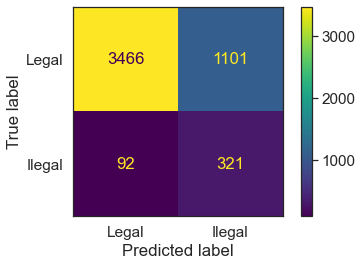

------------------------
Análisis de la curva ROC
AUC del modelo: 0.8520
Best ROC Threshold value = 0.5029


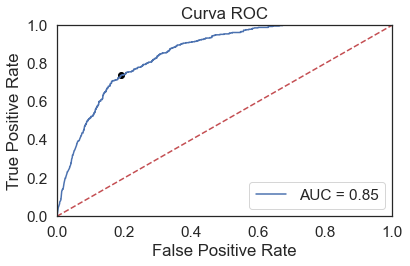

# Metricas con threshold optimo de la curva ROC
Accuracy del train: 0.8182
Accuracy del test: 0.8022
Precision del train: 0.2725
Precision del test: 0.2580
Recall del train: 0.8006
Recall del test: 0.7385
F1 del train: 0.4066
F1 del test: 0.3824
------------------------
Análisis de la curva Precision-Recall (P-R)
Best P-R Threshold = 0.5057, F-Score = 0.4038


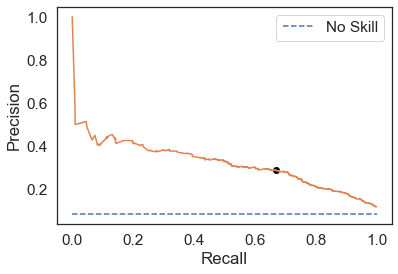

# Metricas con threshold optimo de la curva P-R:
Accuracy del train: 0.8491
Accuracy del test: 0.8363
Precision del train: 0.3036
Precision del test: 0.2893
Recall del train: 0.7268
Recall del test: 0.6683
F1 del train: 0.4283
F1 del test: 0.4038
------------------------
Resultados del GridSerch:
{'mean_fit_time': array([0.97089586, 0.98666549, 0.9501658 , 1.18615193, 1.17153535,
       1.10214996]), 'std_fit_time': array([0.02750875, 0.05043578, 0.01946365, 0.10628545, 0.04677732,
       0.05109884]), 'mean_score_time': array([0.14080229, 0.13795729, 0.13182559, 0.13970666, 0.14665103,
       0.13302698]), 'std_score_time': array([0.00434948, 0.00375851, 0.00196371, 0.00228735, 0.01130947,
       0.00417996]), 'param_modelo_base__alpha': masked_array(data=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_modelo_base__colsample_bytree': masked_array(data=[0.5, 0.5, 0.5, 1, 1, 1],
      

In [92]:
#ocultar warning de xgboost
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

param_grid = {'modelo_base__gamma': [5.0],
              'modelo_base__max_depth': [5],
              'modelo_base__colsample_bytree': [0.5, 1],
              'modelo_base__alpha': [1.0],
              'modelo_base__subsample': [1.0],
              'modelo_base__learning_rate':[0.000287517],
              'modelo_base__random_state':[3,10,15]
              }


create_pipeline(XGBClassifier(verbosity=0, scale_pos_weight=13), param_grid, X_train, #verbosity=0 evita warnings del modelo
                X_test, y_train, y_test, X_val, y_val)


2 - Entrenamiento LogisticRegression


METRICAS DEL ENTRENAMIENTO:
# Metricas con threshold by default
Accuracy del train: 0.8001
Accuracy del test: 0.7745
Precision del train: 0.7953
Precision del test: 0.2394
Recall del train: 0.8084
Recall del test: 0.7893
F1 del train: 0.8018
F1 del test: 0.3673


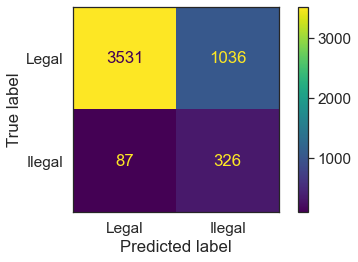

------------------------
Análisis de la curva ROC
AUC del modelo: 0.8428
Best ROC Threshold value = 0.5072


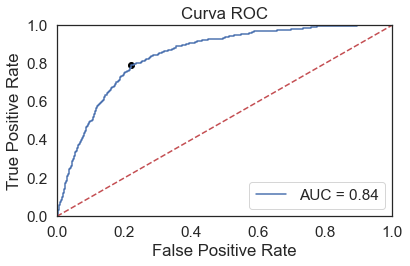

# Metricas con threshold optimo de la curva ROC
Accuracy del train: 0.7994
Accuracy del test: 0.7789
Precision del train: 0.7971
Precision del test: 0.2433
Recall del train: 0.8033
Recall del test: 0.7893
F1 del train: 0.8002
F1 del test: 0.3719
------------------------
Análisis de la curva Precision-Recall (P-R)
Best P-R Threshold = 0.9498, F-Score = nan


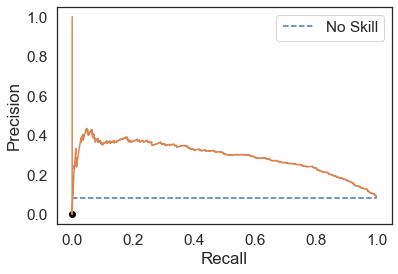

# Metricas con threshold optimo de la curva P-R:
Accuracy del train: 0.5039
Accuracy del test: 0.9157
Precision del train: 0.9184
Precision del test: 0.0000
Recall del train: 0.0085
Recall del test: 0.0000
F1 del train: 0.0169
F1 del test: 0.0000
------------------------
Resultados del GridSerch:
{'mean_fit_time': array([0.19999971, 0.21159964, 0.21359992, 0.2369998 ]), 'std_fit_time': array([0.01586182, 0.00656047, 0.0052002 , 0.0140288 ]), 'mean_score_time': array([0.01319947, 0.01179996, 0.01099992, 0.01200004]), 'std_score_time': array([0.00074816, 0.00074849, 0.00109506, 0.0010955 ]), 'param_modelo_base__C': masked_array(data=[0.1, 0.5, 1, 1.5],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_modelo_base__max_iter': masked_array(data=[200, 200, 200, 200],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_modelo_base__multi_class': masked_array(data=['ovr', 'ovr', 'ovr', 

In [61]:
param_grid = {'modelo_base__C':  [0.1, 0.5, 1, 1.5],
              'modelo_base__random_state': [0],
              'modelo_base__penalty':['l2'],
              'modelo_base__multi_class':['ovr'],
              'modelo_base__max_iter':[200]}
                

create_pipeline(LogisticRegression(),param_grid,X_over_train, X_test, y_over_train, y_test, X_val, y_val)

3 - Entrenamiento LightGBM


METRICAS DEL ENTRENAMIENTO:
# Metricas con threshold by default
Accuracy del train: 0.8293
Accuracy del test: 0.7982
Precision del train: 0.3028
Precision del test: 0.2562
Recall del train: 0.9169
Recall del test: 0.7530
F1 del train: 0.4552
F1 del test: 0.3823


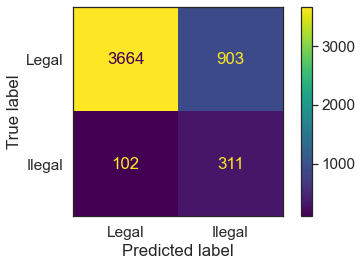

------------------------
Análisis de la curva ROC
AUC del modelo: 0.8535
Best ROC Threshold value = 0.4702


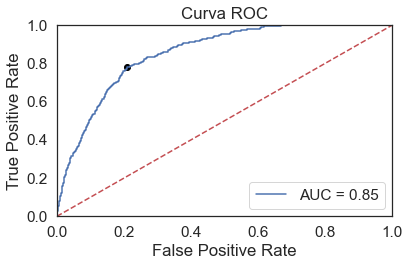

# Metricas con threshold optimo de la curva ROC
Accuracy del train: 0.8195
Accuracy del test: 0.7898
Precision del train: 0.2925
Precision del test: 0.2523
Recall del train: 0.9313
Recall del test: 0.7821
F1 del train: 0.4452
F1 del test: 0.3816
------------------------
Análisis de la curva Precision-Recall (P-R)
Best P-R Threshold = 0.6262, F-Score = 0.3976


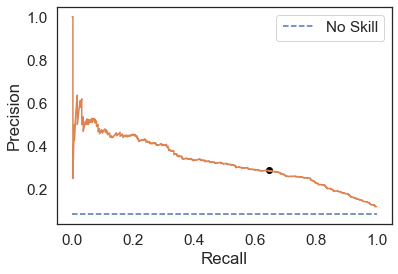

# Metricas con threshold optimo de la curva P-R:
Accuracy del train: 0.8684
Accuracy del test: 0.8376
Precision del train: 0.3532
Precision del test: 0.2871
Recall del train: 0.8335
Recall del test: 0.6465
F1 del train: 0.4962
F1 del test: 0.3976
------------------------
Resultados del GridSerch:
{'mean_fit_time': array([0.58400702, 0.55399017]), 'std_fit_time': array([0.06594184, 0.02166038]), 'mean_score_time': array([0.14671149, 0.13963003]), 'std_score_time': array([0.00977397, 0.00566562]), 'param_modelo_base__force_col_wise': masked_array(data=['true', 'true'],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_modelo_base__learning_rate': masked_array(data=[0.05, 0.05],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_modelo_base__max_depth': masked_array(data=[8, 20],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_modelo_base__n_estimators': masked_array

In [72]:
params = {
'modelo_base__num_class':[1],
'modelo_base__max_depth':[8,20],
'modelo_base__num_leaves':[10],
'modelo_base__learning_rate':[0.05],
'modelo_base__n_estimators':[500],
'modelo_base__force_col_wise': ['true'],
'modelo_base__random_state': [0],
}

create_pipeline(LGBMClassifier(scale_pos_weight=10, verbose=0), params, X_train, X_test, y_train, y_test, X_val, y_val) #verbose evita las warnings
 
 


METRICAS DEL ENTRENAMIENTO:
# Metricas con threshold by default
Accuracy del train: 0.8221
Accuracy del test: 0.7556
Precision del train: 0.8014
Precision del test: 0.2224
Recall del train: 0.8566
Recall del test: 0.7797
F1 del train: 0.8281
F1 del test: 0.3461


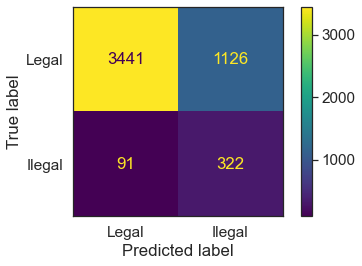

------------------------
Análisis de la curva ROC
AUC del modelo: 0.8526
Best ROC Threshold value = 0.5717


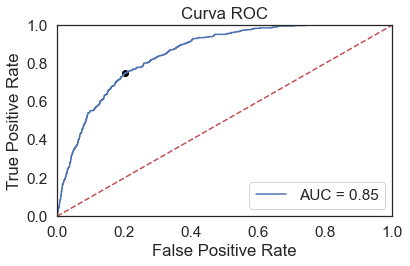

# Metricas con threshold optimo de la curva ROC
Accuracy del train: 0.8226
Accuracy del test: 0.7922
Precision del train: 0.8236
Precision del test: 0.2496
Recall del train: 0.8211
Recall del test: 0.7506
F1 del train: 0.8223
F1 del test: 0.3746
------------------------
Análisis de la curva Precision-Recall (P-R)
Best P-R Threshold = 0.8757, F-Score = nan


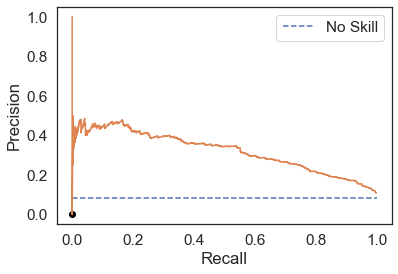

# Metricas con threshold optimo de la curva P-R:
Accuracy del train: 0.5007
Accuracy del test: 0.9169
Precision del train: 0.8889
Precision del test: 0.0000
Recall del train: 0.0015
Recall del test: 0.0000
F1 del train: 0.0030
F1 del test: 0.0000
------------------------
Resultados del GridSerch:
{'mean_fit_time': array([0.75186729]), 'std_fit_time': array([0.02843487]), 'mean_score_time': array([0.0267983]), 'std_score_time': array([0.00213711]), 'param_modelo_base__criterion': masked_array(data=['entropy'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_modelo_base__max_depth': masked_array(data=[5],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_modelo_base__random_state': masked_array(data=[15],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'modelo_base__criterion': 'entropy', 'modelo_base__max_depth': 5, 'modelo_base__random_state': 15}], 'split0_test_score': array(

In [81]:
param_grid = {'modelo_base__criterion':  [  'entropy' ],
              'modelo_base__max_depth': [5],
              'modelo_base__random_state': [15],
 
              }

create_pipeline(RandomForestClassifier(), param_grid,
                X_over_train, X_test, y_over_train, y_test, X_val, y_val)


________________________________________________________

# Modelado con tuning

In [ ]:
dict_models = {
    'xgb': XGBClassifier(),
    'lgbm': LGBMClassifier()
}

In [ ]:
dict_param = {
    'xgb':{
        'xgb__gamma': [0], # Da mejor con todos los resampleos
        'xgb__max_depth': [13, None], # pruebo entre 13 y none, menor a 13 da peor
        'xgb__colsample_bytree': [0.5],
        'xgb__alpha': [1.0], 
        'xgb__lambda': [0.0169],
        'xgb__min_child_weight': [1, 3],
        'xgb__subsample': [1.0],
        'xgb__learning_rate':[0.020], # Da mejor con todos los resampleos
        'xgb__scale_pos_weight': [1 ,1.5 ,3], # Del entorno de 1, porque se usa resampleo y queda balanceado
        'xgb__verbosity': [0],
        'sampleo__random_state':[0] 
    },
    'lgbm':{
        'lgbm__max_depth':[13, None], # pruebo entre 13 y none, menor a 13 da peor
        'lgbm__random_state': [0],
        'lgbm__num_leaves': [65, 80, 95],
        'lgbm__feature_fraction': [0.1],
        'lgbm__scale_pos_weight': [1 ,1.5 ,3], # Del entorno de 1, porque se usa resampleo y queda balanceado
        'lgbm__verbose': [-1],
        'sampleo__random_state':[0]
    }
}

In [ ]:
# DEJO en False, para no pisar accidentalmente lo guardado

save_best_pipes = False

In [ ]:
# fc para poner a correr la grilla de parametros de cada modelo y devolver el pipe del mejor valuado en f1-score.
def run_grid_models(dict_models,  dict_param, score = 'f1'):
    
    cv_results = [] # para guadar la lista de dataframes con los valores de cv en excel
    dict_best_pipelines = dict() 
    dict_best_params = dict()
    
    fold = KFold(n_splits=4, random_state=1, shuffle=True) # para la validacion cruzada en gridsearch
    
    for model, params in zip(dict_models.items(), dict_param.items()):
        print()
        print('Modelo: ', model[0])
        
        print('params[1]: ', params[1])

        for k, Sampleo in dict({'smote':SMOTE(), 'oversampler':RandomOverSampler(),'undersampler':RandomUnderSampler()}).items():
            print(k)
            print()
            pipeline = Pipeline_imblearn([(('preprocesador',preprocesador)),
                                ('sampleo', Sampleo), 
                                (model[0], model[1])])
            #print(pipeline)

            #Ejecuto GridSearchCV por única vez
            grid = GridSearchCV(pipeline,
                        param_grid=params[1],
                        cv=fold,
                        n_jobs=-1,
                        scoring = score
                        )

            grid.fit(X_train, y_train)

            del pipeline 

            print("Best parameter (" + score + " score=%0.3f):" % grid.best_score_)
            best_params = grid.best_params_
            dict_best_params[model[0]+'_'+k] = best_params
            print(best_params)

            cv_results.append(pd.DataFrame(grid.cv_results_))

            del grid

            # reescribo los hiperparametros en el formato necesario para escribir el nuevo pipeline de mejores hiperparametros:
            smote_params = {k.split('__')[1]:l for k, l in best_params.items() if k.startswith('sampleo')}
            clf_params = {k.split('__')[1]:l for k,l in best_params.items() if not k.startswith('sampleo')}

            dict_best_pipelines[model[0]+'_'+k] = Pipeline_imblearn([('sampleo' , Sampleo.set_params(**smote_params)),
                                  (model[0], model[1].set_params(**clf_params))])
            print('--'*10)

    
    if save_best_pipes:
        joblib.dump(dict_best_pipelines, os.path.join('results','dict_best_pipelines.h5'))
    
    return dict_best_pipelines

In [ ]:
dict_best_pipelines = run_grid_models(dict_models,  dict_param)


Modelo:  xgb
params[1]:  {'xgb__gamma': [0], 'xgb__max_depth': [13, None], 'xgb__colsample_bytree': [0.5], 'xgb__alpha': [1.0], 'xgb__lambda': [0.0169], 'xgb__min_child_weight': [1, 3], 'xgb__subsample': [1.0], 'xgb__learning_rate': [0.02], 'xgb__scale_pos_weight': [1, 1.5, 3], 'xgb__verbosity': [0], 'sampleo__random_state': [0]}
smote

Best parameter (f1 score=0.402):
{'sampleo__random_state': 0, 'xgb__alpha': 1.0, 'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0, 'xgb__lambda': 0.0169, 'xgb__learning_rate': 0.02, 'xgb__max_depth': None, 'xgb__min_child_weight': 1, 'xgb__scale_pos_weight': 1.5, 'xgb__subsample': 1.0, 'xgb__verbosity': 0}
--------------------
oversampler

Best parameter (f1 score=0.405):
{'sampleo__random_state': 0, 'xgb__alpha': 1.0, 'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0, 'xgb__lambda': 0.0169, 'xgb__learning_rate': 0.02, 'xgb__max_depth': 13, 'xgb__min_child_weight': 3, 'xgb__scale_pos_weight': 1.5, 'xgb__subsample': 1.0, 'xgb__verbosity': 0}
------------------

**Cross validation para seleccionar el mejor modelo**

In [ ]:
dict_best_pipelines = joblib.load(os.path.join('results','dict_best_pipelines.h5'))

In [ ]:
dict_selected_pipelines = {k:v for k,v in dict_best_pipelines.items() if k.split('_')[0] in ['xgb','lgbm']}
dict_selected_pipelines.keys()

dict_keys(['xgb_smote', 'xgb_oversampler', 'xgb_undersampler', 'lgbm_smote', 'lgbm_oversampler', 'lgbm_undersampler'])

In [ ]:
# DEJO en False, para no pisar accidentalmente lo guardado
save_cv_results = False

def run_crossval(dict_best_pipelines):
    '''
     Cross validation entre modelos seleccionados
    
    Argumentos:
    ----------
    dict_best_pipelines ---------- resultado guardado de mejores hiperparametros de cada modelo
    

    '''
    cv_results = pd.DataFrame() 
    
    for model_name, model in dict_best_pipelines.items():
        print(model_name)

        #Creo el pipe_model, para incluir al preprocesador
        pipe_model = Pipeline([
                        ('preprocesador',preprocesador),
                        ('modelo',model)
                        ])
        
        fold = KFold(n_splits=6, random_state=1, shuffle=True)
        
        scores = cross_validate(pipe_model,
                                 X_train,
                                 y_train,
                                 scoring=['accuracy', 'recall', 'precision', 'f1'],
                                 cv=fold,
                                 n_jobs=-1)
    
        print('-------Results------')
        print('----Validation------')
        print('Accuracy Validation: {:.4f}'.format(scores['test_accuracy'].mean()))
        print('Recall Validation: {:.4f}'.format(scores['test_recall'].mean()))
        print('Precision Validation: {:.4f}'.format(scores['test_precision'].mean()))
        print('F1 Validation: {:.4f}'.format(scores['test_f1'].mean()))
 
        scores = pd.DataFrame(scores)
        scores.columns = scores.columns.map(lambda x: model_name + '_' + x) #Estaba cambiado "columns" por "row"
        cv_results = pd.concat([cv_results, scores], axis = 1)
        
        pipe_model.fit(X_train, y_train)
        y_pred_test = pipe_model.predict(X_test)

        recall = recall_score(y_test, y_pred_test)
        precision = precision_score(y_test, y_pred_test)
        acc = accuracy_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test)
        
        print('----Test------')
        print('Accuracy Test: {:.4f}'.format(acc))
        print('Recall Test: {:.4f}'.format(recall))
        print('Precision Test: {:.4f}'.format(precision))
        print('F1 Test: {:.4f}'.format(f1))
        print()
        print('--'*30)
        
    if save_cv_results:
        cv_results.to_csv(os.path.join('results','cv_results.csv'), index=False)
        
    return cv_results


In [ ]:
#establecemos variable en False para no correr nuevamente el proceso.
run = False #Corro la función run_crossval
if run:
    cv_results = run_crossval(dict_selected_pipelines)
else:
    cv_results = pd.read_csv(os.path.join('results','cv_results.csv')) #Cambio nombre a standarized
cv_results  

,xgb_smote_fit_time,xgb_smote_score_time,xgb_smote_test_accuracy,xgb_smote_test_recall,xgb_smote_test_precision,xgb_smote_test_f1,xgb_oversampler_fit_time,xgb_oversampler_score_time,xgb_oversampler_test_accuracy,xgb_oversampler_test_recall,xgb_oversampler_test_precision,xgb_oversampler_test_f1,xgb_undersampler_fit_time,xgb_undersampler_score_time,xgb_undersampler_test_accuracy,xgb_undersampler_test_recall,xgb_undersampler_test_precision,xgb_undersampler_test_f1,lgbm_smote_fit_time,lgbm_smote_score_time,lgbm_smote_test_accuracy,lgbm_smote_test_recall,lgbm_smote_test_precision,lgbm_smote_test_f1,lgbm_oversampler_fit_time,lgbm_oversampler_score_time,lgbm_oversampler_test_accuracy,lgbm_oversampler_test_recall,lgbm_oversampler_test_precision,lgbm_oversampler_test_f1,lgbm_undersampler_fit_time,lgbm_undersampler_score_time,lgbm_undersampler_test_accuracy,lgbm_undersampler_test_recall,lgbm_undersampler_test_precision,lgbm_undersampler_test_f1
0,18.03,0.05,0.85,0.63,0.28,0.39,15.80,0.09,0.80,0.83,0.26,0.39,2.93,0.15,0.77,0.86,0.24,0.37,3.85,0.09,0.90,0.23,0.31,0.27,3.88,0.10,0.82,0.73,0.27,0.39,2.52,0.18,0.77,0.84,0.23,0.36
1,17.25,0.09,0.85,0.65,0.32,0.43,14.21,0.10,0.80,0.85,0.27,0.41,2.88,0.18,0.76,0.89,0.24,0.38,3.77,0.13,0.90,0.26,0.35,0.30,3.26,0.08,0.82,0.77,0.29,0.42,3.01,0.07,0.76,0.86,0.24,0.37
2,17.88,0.04,0.86,0.63,0.33,0.43,15.84,0.11,0.82,0.78,0.29,0.42,2.86,0.09,0.78,0.85,0.26,0.39,3.60,0.08,0.90,0.27,0.39,0.32,3.25,0.08,0.83,0.70,0.30,0.42,2.51,0.11,0.78,0.83,0.26,0.39
3,18.04,0.05,0.86,0.64,0.29,0.40,15.80,0.09,0.81,0.80,0.25,0.38,2.85,0.10,0.78,0.82,0.23,0.35,3.73,0.12,0.90,0.24,0.31,0.27,3.91,0.08,0.83,0.72,0.27,0.39,2.50,0.10,0.77,0.84,0.22,0.35
4,18.09,0.05,0.86,0.61,0.29,0.40,15.86,0.06,0.80,0.77,0.25,0.38,2.94,0.11,0.78,0.82,0.24,0.37,3.71,0.13,0.90,0.27,0.35,0.30,3.09,0.09,0.83,0.71,0.28,0.40,2.58,0.11,0.77,0.80,0.23,0.36
5,17.25,0.09,0.86,0.62,0.27,0.37,15.82,0.06,0.80,0.76,0.22,0.34,3.06,0.07,0.77,0.82,0.20,0.32,3.62,0.11,0.91,0.22,0.29,0.25,3.06,0.09,0.83,0.69,0.25,0.36,2.74,0.09,0.77,0.80,0.20,0.32


In [ ]:
#Sacamos de cv_results los mejores 4 modelos respecto de f1

best_4models = cv_results.filter(like='f1').mean().sort_values(ascending=False).head(4).index.to_list()

for i in range(0,len(best_4models)):
    best_4models[i] = best_4models[i][:-8]

best_4models

['xgb_smote', 'lgbm_oversampler', 'xgb_oversampler', 'xgb_undersampler']

In [ ]:
recall_results = cv_results[[m+'_test_recall' for m in best_4models]]
accuracy_results = cv_results[[m+'_test_accuracy' for m in best_4models]]
precision_results = cv_results[[m+'_test_precision' for m in best_4models]]
f1_results = cv_results[[m+'_test_f1' for m in best_4models]]

In [ ]:
def plot_folds_metrics(df):   
    sns.set(font_scale=1.7)

    plt.figure(figsize=(8,6))
    g = sns.lineplot(data = df)
    
    g.legend(bbox_to_anchor=(1.05, 1.), loc=2, borderaxespad=0.05)
    for lab in g.legend_.texts:
        lab.set_text(lab.get_text())
    

    g.set_xticks([0, 1, 2, 3, 4, 5])
    
    m = df.columns[0].split('_')[-1]
    
    g.set_title('Métrica '+ m, fontsize=18,  weight='bold')
    

                              recall_results
xgb_smote_test_recall                   0.63
lgbm_oversampler_test_recall            0.72
xgb_oversampler_test_recall             0.80
xgb_undersampler_test_recall            0.84
                                accuracy_results
xgb_smote_test_accuracy                     0.85
lgbm_oversampler_test_accuracy              0.83
xgb_oversampler_test_accuracy               0.80
xgb_undersampler_test_accuracy              0.77
                                 precision_results
xgb_smote_test_precision                      0.30
lgbm_oversampler_test_precision               0.27
xgb_oversampler_test_precision                0.26
xgb_undersampler_test_precision               0.23
                          f1_results
xgb_smote_test_f1               0.40
lgbm_oversampler_test_f1        0.40
xgb_oversampler_test_f1         0.39
xgb_undersampler_test_f1        0.37


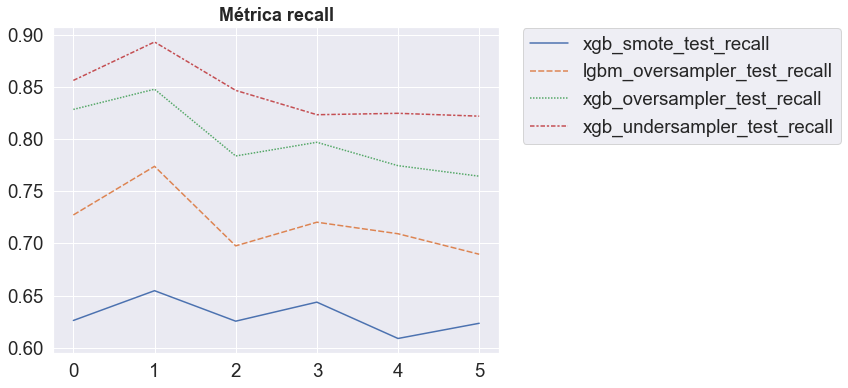

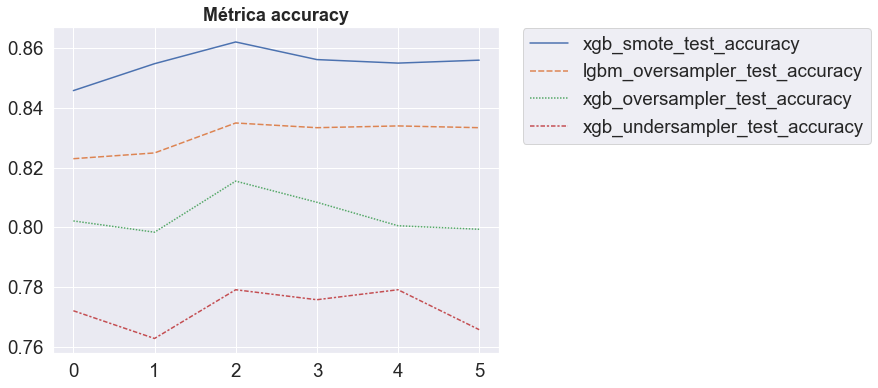

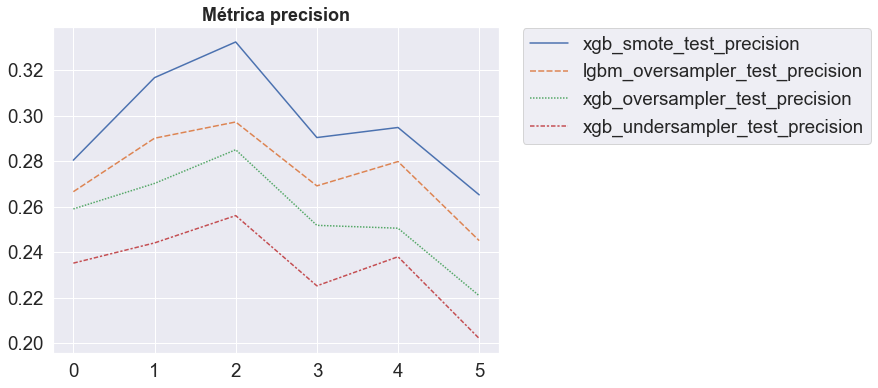

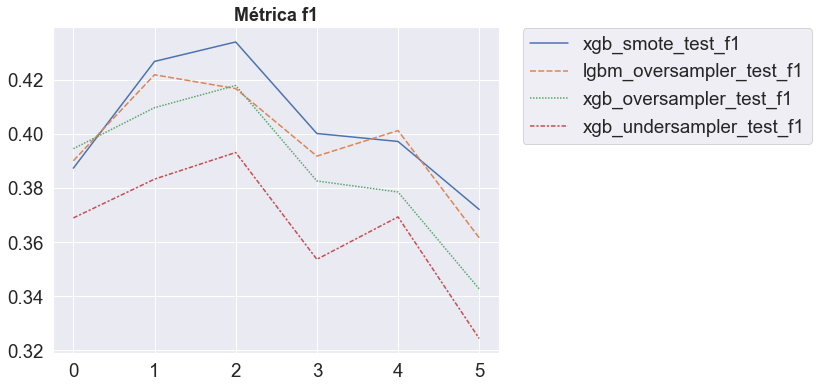

In [ ]:
#corremos los modelos para graficarlos
models=[recall_results,accuracy_results,precision_results,f1_results]

for m in models:
        vnames = [name for name in globals() if globals()[name] is m]
        print(m.mean().to_frame(vnames[0]))
        m
        plot_folds_metrics(m)